<a href="https://colab.research.google.com/github/Saultr21/IA-Y-BIGDATA/blob/main/SNS/SNS_ACT3_7/Terremoto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Parte 1: Importación de librerías y carga de datos**

In [ ]:
#!pip install lazypredict
#!pip install optuna


Este fragmento de código prepara el entorno para el análisis y modelado de datos:

- **Importa librerías** esenciales para:
  - Manipulación de datos: `pandas`, `numpy`
  - Visualización: `matplotlib`, `seaborn`
  - Machine Learning: `sklearn`, `lightgbm`, `lazypredict`
  - Selección de características y optimización de modelos

- **Configura visualizaciones** con estilos predefinidos.

- **Carga los datasets** desde GitHub en DataFrames y muestra sus dimensiones para verificar su correcta importación.

Esto sienta las bases para el análisis exploratorio y la construcción de modelos predictivos.

In [ ]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import pickle
import warnings
import optuna
from scipy.cluster import hierarchy
from tqdm.notebook import tqdm
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    ParameterSampler,
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    accuracy_score,
    make_scorer,
)
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('fivethirtyeight')
sns.set_palette("Set2")

# Carga de datos
# URLs de los datasets en GitHub
train_values_url = "https://raw.githubusercontent.com/Saultr21/IA-Y-BIGDATA/refs/heads/main/SNS/SNS_ACT3_7/train_values.csv"
train_labels_url = "https://raw.githubusercontent.com/Saultr21/IA-Y-BIGDATA/refs/heads/main/SNS/SNS_ACT3_7/train_labels.csv"
test_values_url  = "https://raw.githubusercontent.com/Saultr21/IA-Y-BIGDATA/refs/heads/main/SNS/SNS_ACT3_7/test_values.csv"

# Cargar los datasets
train_values = pd.read_csv(train_values_url)
train_labels = pd.read_csv(train_labels_url)
test_values  = pd.read_csv(test_values_url)
print("Dimensiones del conjunto de datos de entrenamiento (features):", train_values.shape)
print("Dimensiones del conjunto de datos de entrenamiento (labels):", train_labels.shape)
print("Dimensiones del conjunto de datos de prueba:", test_values.shape)

# Verificar los primeros registros
train_values.head()

C:\Users\isard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dimensiones del conjunto de datos de entrenamiento (features): (260601, 39)
Dimensiones del conjunto de datos de entrenamiento (labels): (260601, 2)
Dimensiones del conjunto de datos de prueba: (86868, 39)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


# **Parte 2: Análisis Exploratorio de Datos (EDA)**


Esta sección realiza un análisis exploratorio para comprender mejor las características del conjunto de datos.

## **1. Fusión de Datos**
- Se combinan las características (`train_values`) con las etiquetas (`train_labels`) utilizando `building_id` como clave.

## **2. Distribución de la Variable Objetivo**
- Se grafica la distribución de la variable `damage_grade` (nivel de daño) en un histograma de barras.
- Se muestran los valores exactos sobre cada barra para facilitar la interpretación.

## **3. Análisis de Características Numéricas**
- Se seleccionan características numéricas clave como `age`, `count_floors_pre_eq`, `area_percentage`, etc.
- Se visualiza su distribución por nivel de daño mediante diagramas de caja (`boxplot`).
- Se genera una **matriz de correlación** para identificar relaciones entre variables.

## **4. Análisis de Características Categóricas**
- Se analizan variables como `foundation_type`, `roof_type` y `ground_floor_type`.
- Se crean gráficos de barras apiladas para visualizar la proporción de cada categoría dentro de cada nivel de daño.

## **5. Identificación de Columnas Binarias**
- Se identifican variables codificadas como `0-1`, lo que puede ser útil para la selección de características.

## **6. Resumen Estadístico**
- Se muestra un resumen de estadísticas descriptivas (`mean`, `std`, `min`, `max`, `percentiles`) de las características numéricas.

Este análisis ayuda a entender mejor la distribución de los datos y a seleccionar las características más relevantes para el modelado.

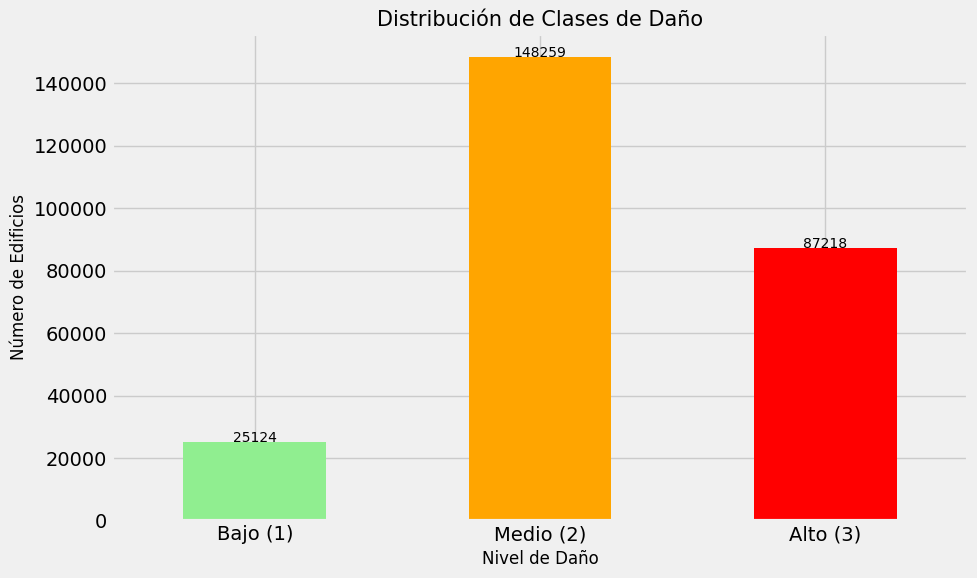

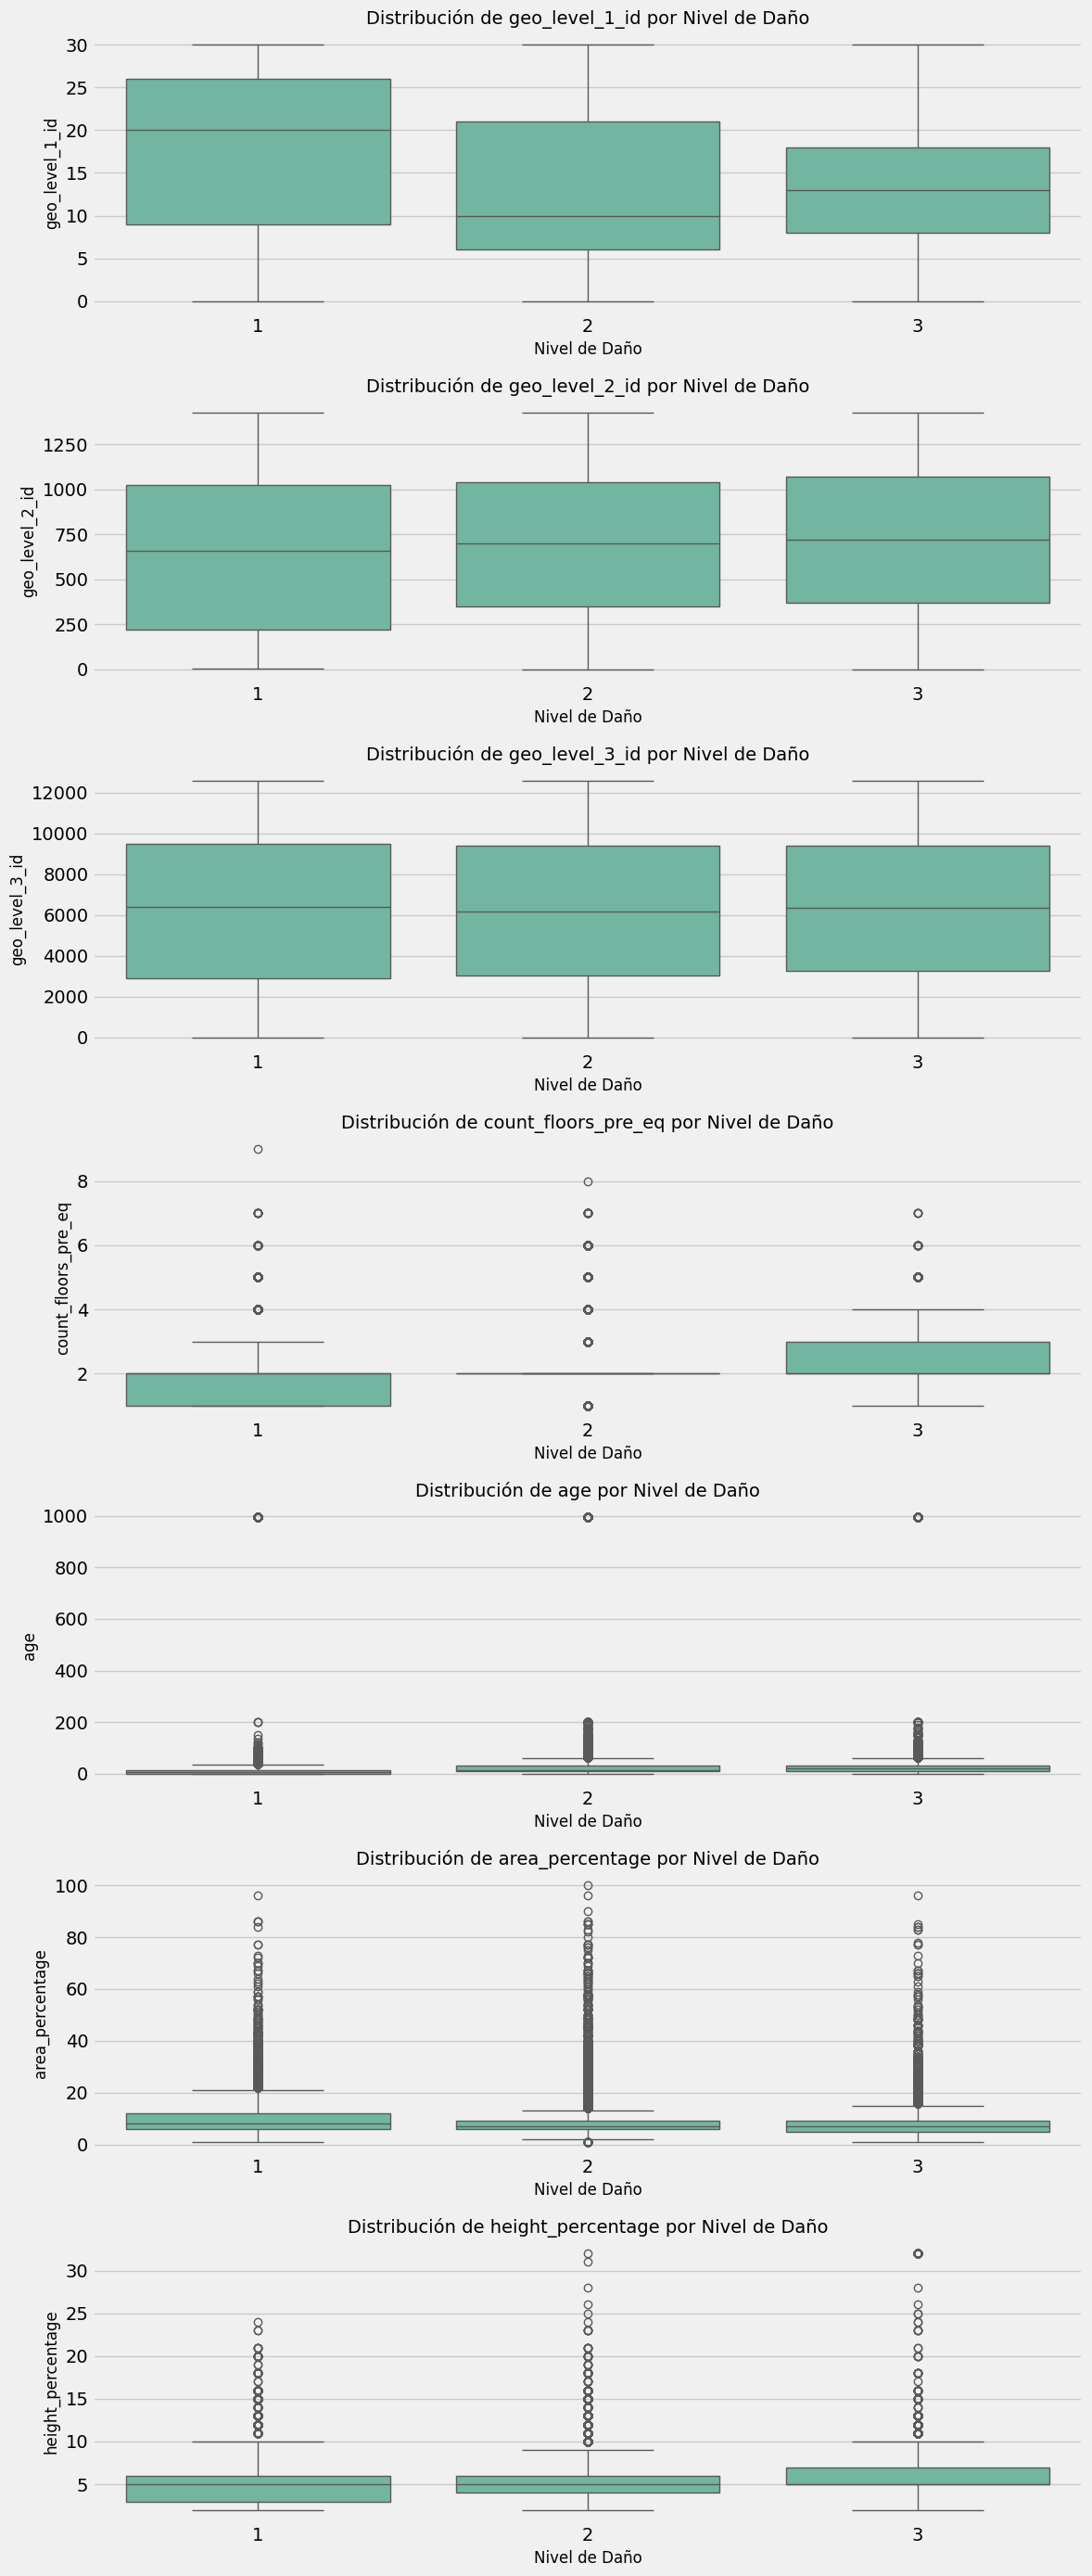

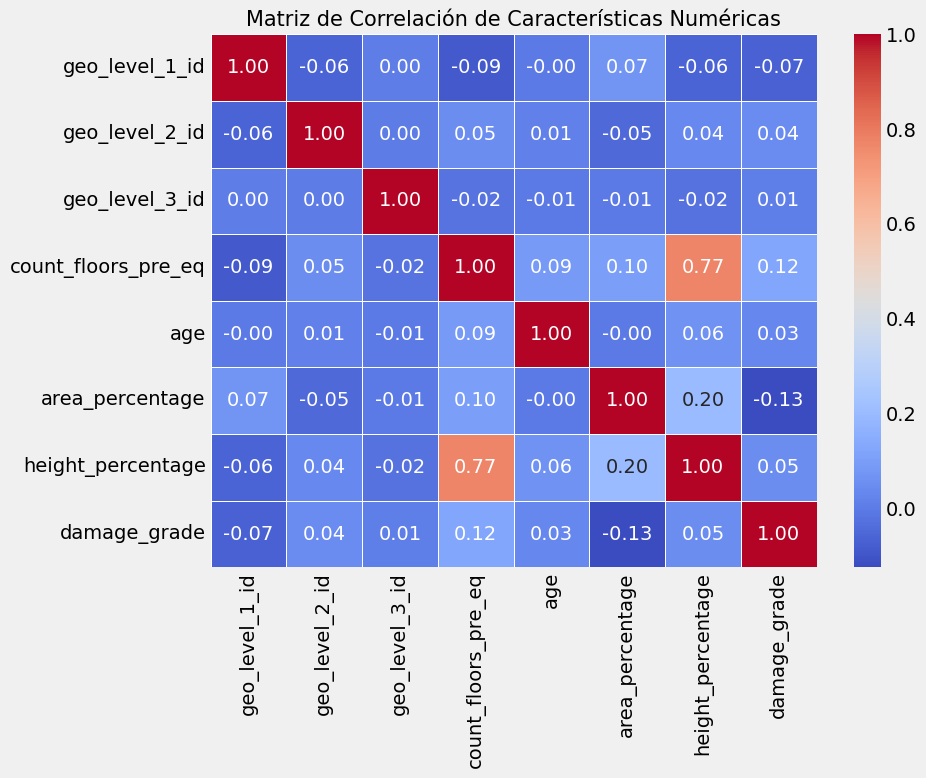

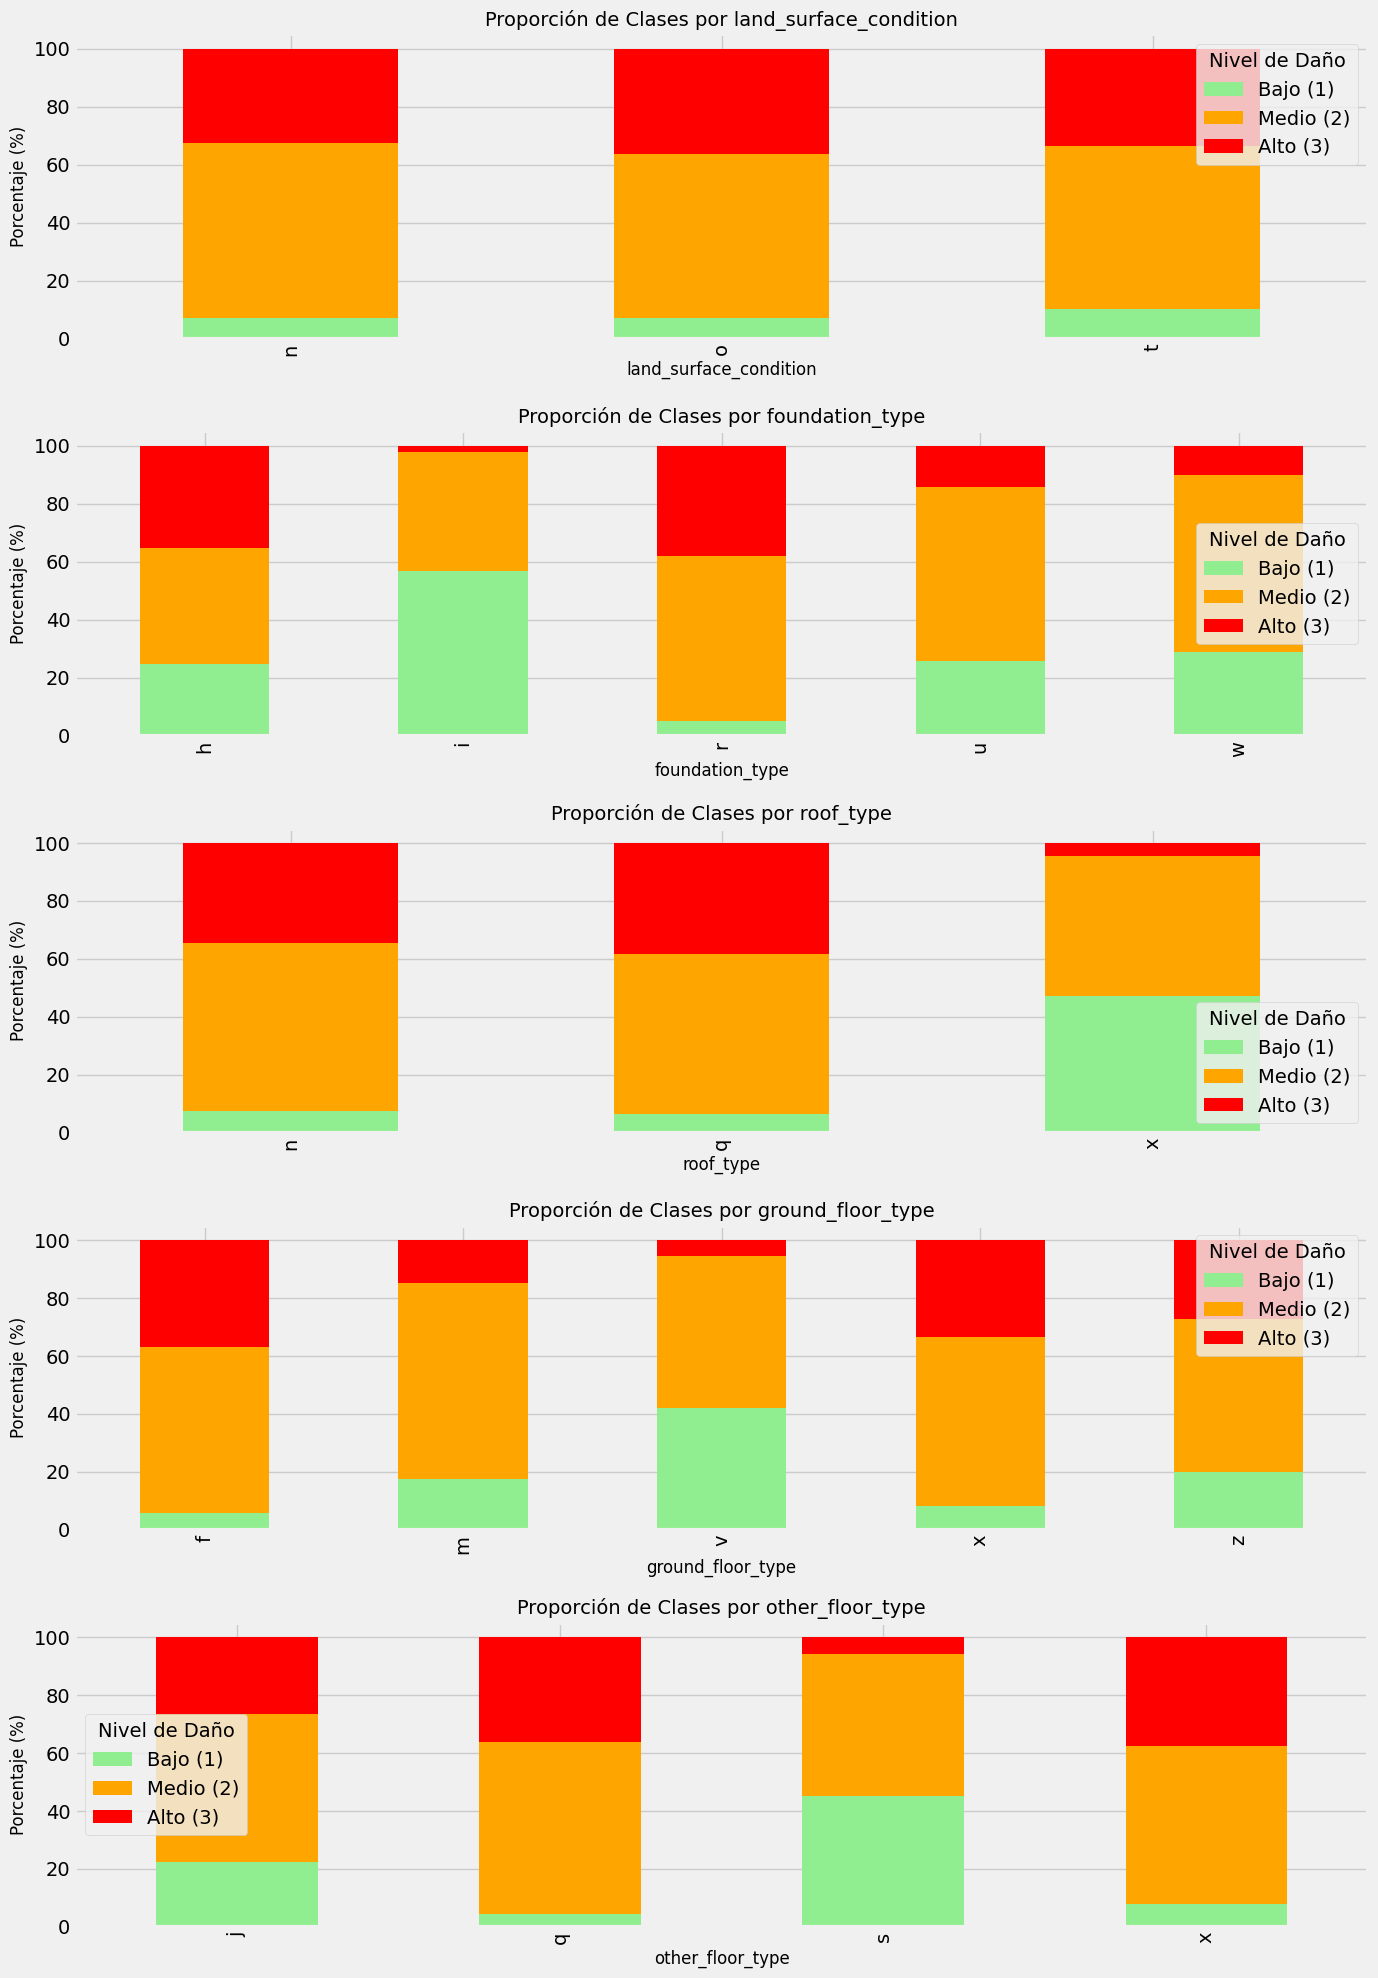

Se identificaron 22 columnas binarias


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage
count,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00
mean,13.90,701.07,6257.88,2.13,26.54,8.02,5.43
std,8.03,412.71,3646.37,0.73,73.57,4.39,1.92
min,0.00,0.00,0.00,1.00,0.00,1.00,2.00
25%,7.00,350.00,3073.00,2.00,10.00,5.00,4.00
50%,12.00,702.00,6270.00,2.00,15.00,7.00,5.00
75%,21.00,1050.00,9412.00,2.00,30.00,9.00,6.00
max,30.00,1427.00,12567.00,9.00,995.00,100.00,32.00


In [ ]:
# Fusionar datos de entrenamiento y etiquetas para el análisis
train_data = pd.merge(train_values, train_labels, on="building_id")

# Explorar distribución de la variable objetivo
plt.figure(figsize=(10, 6))
damage_counts = train_data['damage_grade'].value_counts().sort_index()
ax = damage_counts.plot(kind='bar', color=['lightgreen', 'orange', 'red'])
plt.title('Distribución de Clases de Daño', fontsize=15)
plt.xlabel('Nivel de Daño', fontsize=12)
plt.ylabel('Número de Edificios', fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=['Bajo (1)', 'Medio (2)', 'Alto (3)'], rotation=0)

# Agregar valores sobre las barras
for i, v in enumerate(damage_counts):
    ax.text(i, v + 50, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Explorar características numéricas
numerical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq',
                      'age', 'area_percentage', 'height_percentage']

fig, axes = plt.subplots(len(numerical_features), 1, figsize=(12, 4*len(numerical_features)))
for i, feature in enumerate(numerical_features):
    sns.boxplot(x='damage_grade', y=feature, data=train_data, ax=axes[i])
    axes[i].set_title(f'Distribución de {feature} por Nivel de Daño', fontsize=14)
    axes[i].set_xlabel('Nivel de Daño', fontsize=12)
    axes[i].set_ylabel(feature, fontsize=12)

plt.tight_layout()
plt.show()

# Matriz de correlación de características numéricas
plt.figure(figsize=(10, 8))
correlation_matrix = train_data[numerical_features + ['damage_grade']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de Características Numéricas', fontsize=15)
plt.tight_layout()
plt.show()

# Análisis de características categóricas
categorical_features = ['land_surface_condition', 'foundation_type', 'roof_type',
                       'ground_floor_type', 'other_floor_type']

fig, axes = plt.subplots(len(categorical_features), 1, figsize=(14, 4*len(categorical_features)))
for i, feature in enumerate(categorical_features):
    # Calcular proporción de cada categoría para cada clase de daño
    cat_proportions = pd.crosstab(train_data[feature], train_data['damage_grade'],
                                   normalize='index') * 100
    cat_proportions.plot(kind='bar', stacked=True, ax=axes[i],
                          color=['lightgreen', 'orange', 'red'])
    axes[i].set_title(f'Proporción de Clases por {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Porcentaje (%)', fontsize=12)
    axes[i].legend(title='Nivel de Daño', labels=['Bajo (1)', 'Medio (2)', 'Alto (3)'])

plt.tight_layout()
plt.show()

# Identificar columnas binarias (codificadas como 0-1)
binary_columns = []
for col in train_values.columns:
    unique_vals = train_values[col].unique()
    if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
        binary_columns.append(col)

print(f"Se identificaron {len(binary_columns)} columnas binarias")

# Resumen estadístico de características numéricas importantes
train_data[numerical_features].describe()

# **Parte 3: Selección de Características Usando Dendrogramas y Correlación**


Esta sección busca identificar las características más relevantes para el modelo mediante análisis de agrupamiento y correlación.

## **1. Generación del Dendrograma**
- Se seleccionan las características numéricas y se **escalan** con `StandardScaler`.
- Se aplica **clustering jerárquico** (`ward linkage`) para identificar similitudes entre variables.
- Se grafica un **dendrograma**, lo que permite visualizar qué características están más relacionadas entre sí.

## **2. Análisis de Correlación**
- Se convierten las variables categóricas en valores numéricos.
- Se calcula la **matriz de correlación** entre las variables y la variable objetivo (`damage_grade`).
- Se usa un **heatmap** para representar visualmente las relaciones más fuertes.

## **3. Selección de Características**
- Se eligen características numéricas y categóricas con mayor relevancia según el dendrograma y la correlación.
- Se añaden **variables binarias** relevantes para enriquecer el modelo.

Esta selección permite reducir la dimensionalidad del dataset y mejorar la eficiencia del modelo predictivo.

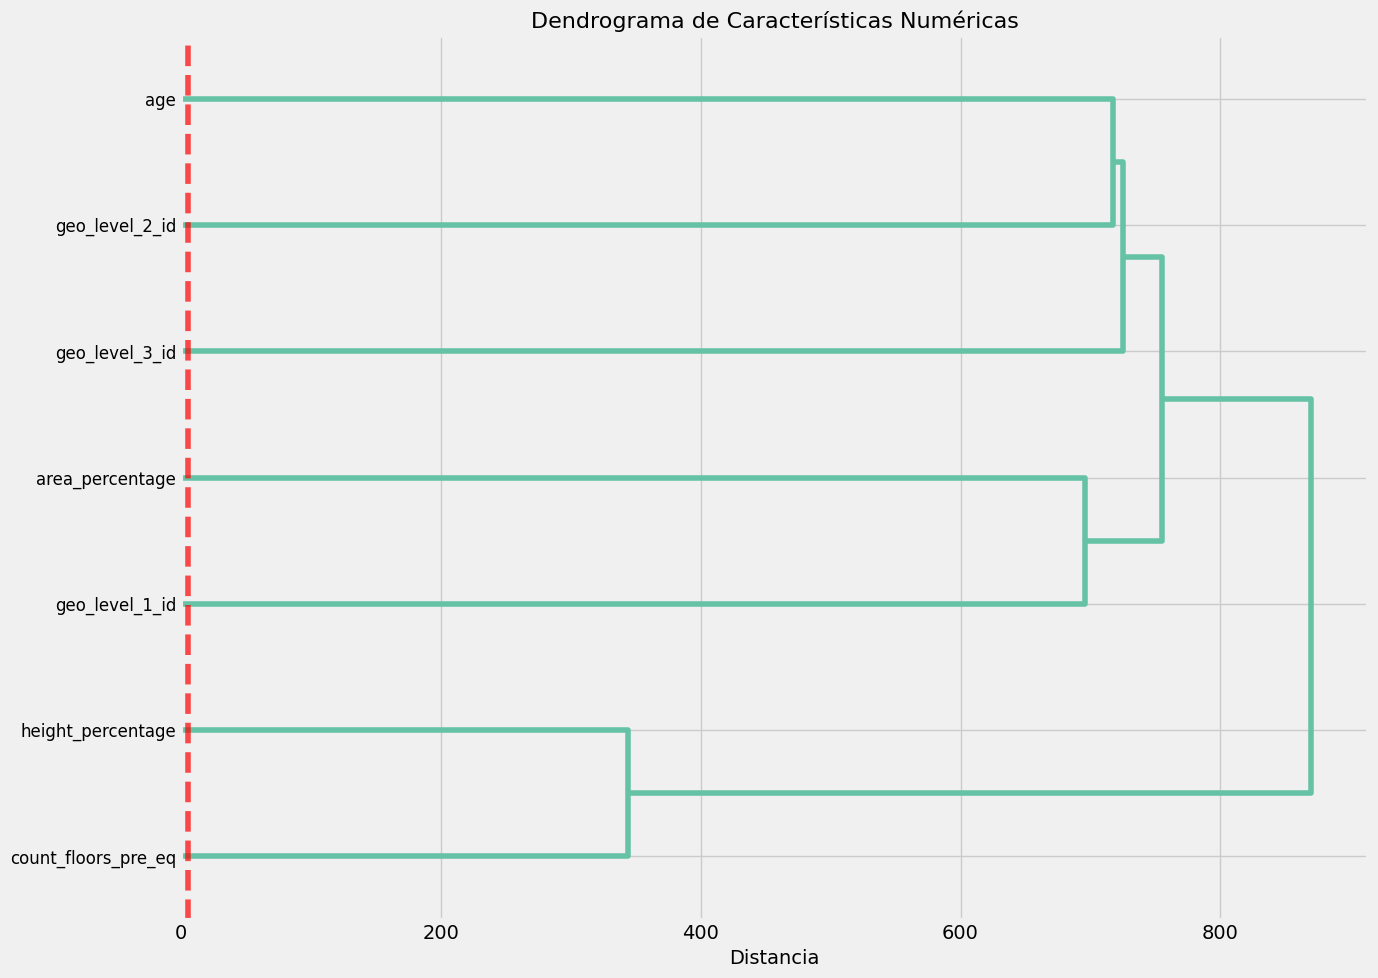

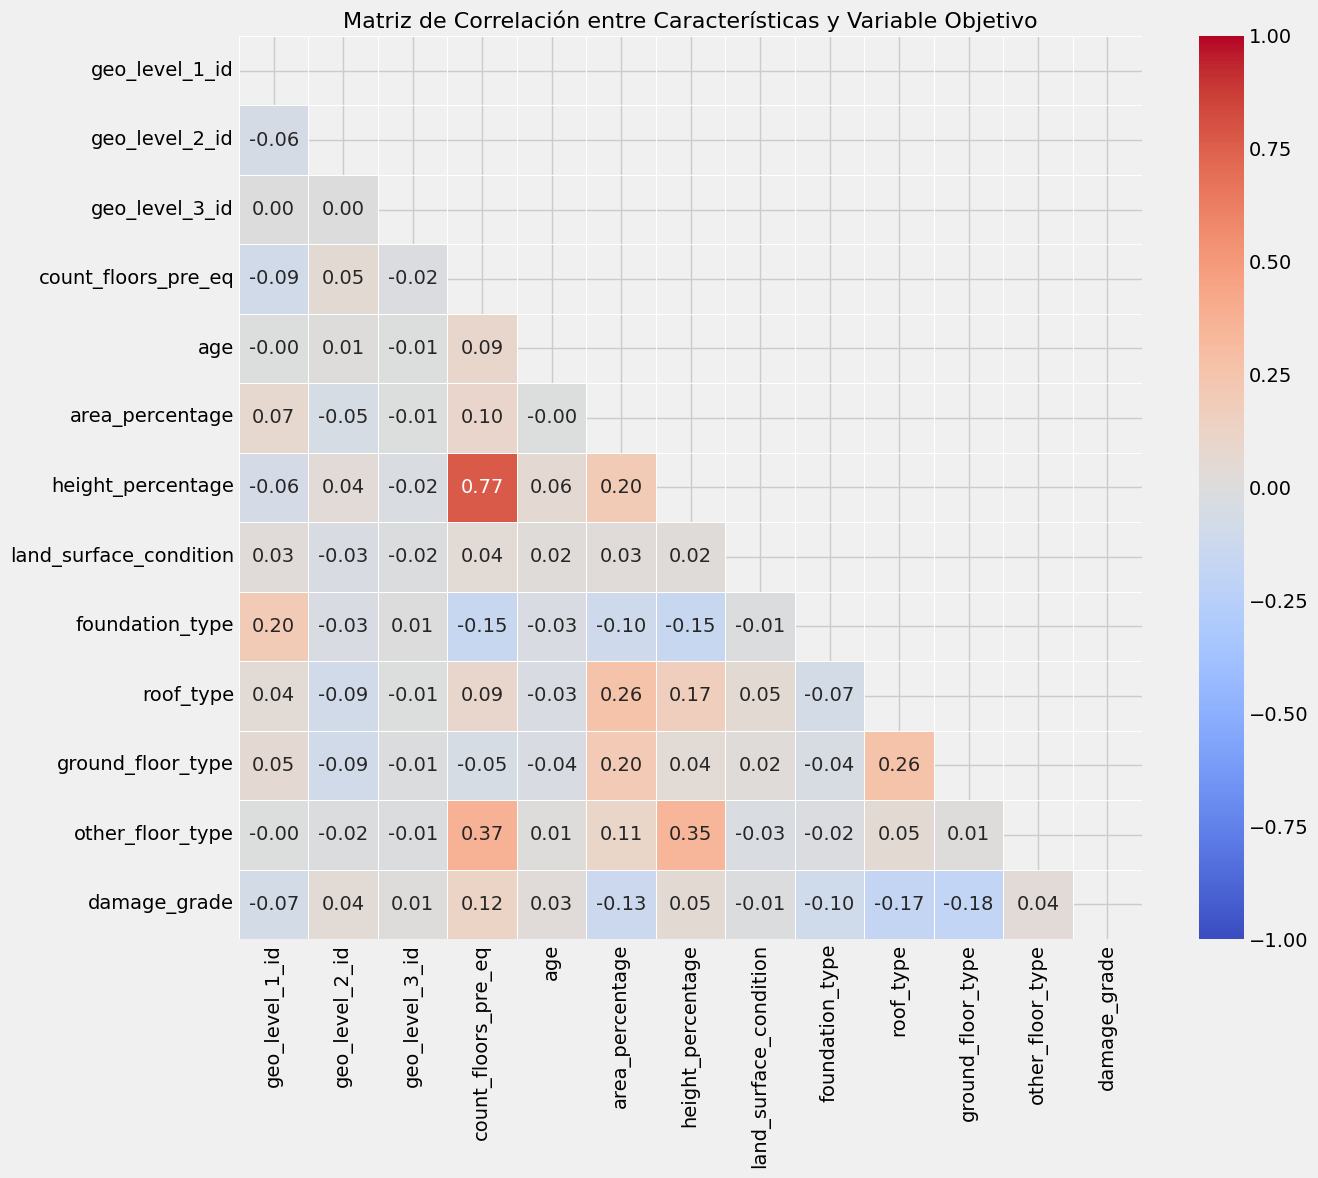

Características seleccionadas para modelado: ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered']


In [ ]:
# Preparación de datos para dendrograma
# Seleccionamos características numéricas
X_numerical = train_data[numerical_features].copy()

# Escalamos los datos para el dendrograma
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Creamos el dendrograma
plt.figure(figsize=(14, 10))
dend = hierarchy.dendrogram(
    hierarchy.linkage(X_scaled.T, method='ward'),  # Transpuesta para clustering de características
    labels=X_numerical.columns,
    orientation='right',
    leaf_font_size=12,
    color_threshold=5
)
plt.title('Dendrograma de Características Numéricas', fontsize=16)
plt.xlabel('Distancia', fontsize=14)
plt.axvline(x=5, color='red', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Análisis de correlación entre características categóricas y numéricas
# Para esto, convertiremos las categóricas a numéricas temporalmente

# Función para convertir características categóricas a numéricas
def convert_categorical_to_numeric(df, categorical_cols):
    df_encoded = df.copy()
    for col in categorical_cols:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    return df_encoded

categorical_cols = [col for col in train_data.columns
                   if train_data[col].dtype == 'object' and col not in ['building_id']]

train_data_encoded = convert_categorical_to_numeric(train_data, categorical_cols)

# Seleccionamos un subset de columnas para el heatmap (para evitar sobrecarga visual)
selected_features = numerical_features + categorical_cols[:5]  # Primeras 5 categóricas
selected_features.append('damage_grade')  # Añadir variable objetivo

plt.figure(figsize=(14, 12))
correlation = train_data_encoded[selected_features].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Matriz de Correlación entre Características y Variable Objetivo', fontsize=16)
plt.tight_layout()
plt.show()

# Basado en el dendrograma y la correlación, seleccionamos las características relevantes
selected_features = [
    'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
    'land_surface_condition', 'foundation_type', 'roof_type',
    'ground_floor_type', 'other_floor_type'
]

# Podemos añadir algunas características adicionales basadas en el dominio
selected_features += [col for col in binary_columns[:10]]  # Añadir primeras 10 columnas binarias

print("Características seleccionadas para modelado:", selected_features)

# **Parte 4: Selección Adicional de Características**


Esta sección aplica distintos métodos de selección de características para identificar las más relevantes en el modelo.

## **1. Conversión de Datos**
- Se convierten las variables categóricas en numéricas.
- Se eliminan columnas innecesarias (`building_id`).

## **2. Métodos de Selección de Características**
### **a) Prueba F (ANOVA)**
- Se aplica `SelectKBest(f_classif)` para seleccionar las 20 mejores características según la prueba F.
- Se visualizan las características con mayor relevancia.

### **b) Información Mutua**
- Se usa `SelectKBest(mutual_info_classif)` para detectar relaciones no lineales.
- Se grafican las principales características seleccionadas.

### **c) Importancia con Random Forest**
- Se entrena un `RandomForestClassifier` y se extraen las características más influyentes.
- Se usa `SelectFromModel` para seleccionar automáticamente las más importantes.

## **3. Análisis con PCA**
- Se aplica Análisis de Componentes Principales (PCA) para reducir la dimensionalidad.
- Se determina cuántos componentes explican el 95% de la varianza.

## **4. Selección Final de Características**
- Se identifican las características en común entre los distintos métodos.
- Se combinan con las obtenidas mediante dendrogramas para una selección más robusta.

Este proceso optimiza la eficiencia del modelo al eliminar variables irrelevantes o redundantes.

===== SELECCIÓN DE CARACTERÍSTICAS ADICIONAL =====

--- Selección basada en prueba F (ANOVA) ---
Top 20 características según prueba F:


,Característica,Puntuación F,P-valor
38,damage_grade,inf,0.00
15,has_superstructure_mud_mortar_stone,16490.39,0.00
19,has_superstructure_cement_mortar_brick,11120.19,0.00
23,has_superstructure_rc_engineered,7757.59,0.00
9,roof_type,6944.70,0.00
10,ground_floor_type,5750.58,0.00
22,has_superstructure_rc_non_engineered,4721.92,0.00
0,geo_level_1_id,2657.79,0.00
3,count_floors_pre_eq,2544.84,0.00
5,area_percentage,2529.05,0.00


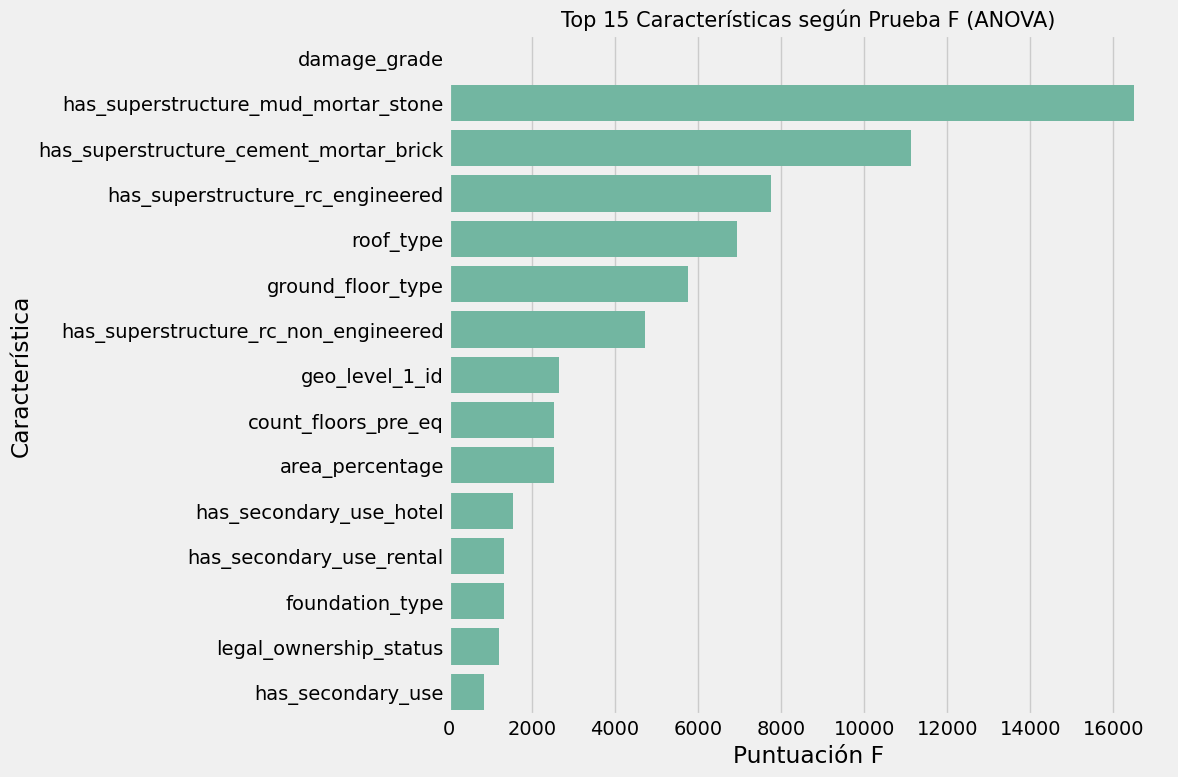


--- Selección basada en Información Mutua ---
Top 20 características según Información Mutua:


,Característica,Información Mutua
38,damage_grade,0.94
2,geo_level_3_id,0.30
1,geo_level_2_id,0.23
0,geo_level_1_id,0.13
8,foundation_type,0.09
15,has_superstructure_mud_mortar_stone,0.07
11,other_floor_type,0.06
10,ground_floor_type,0.05
9,roof_type,0.04
3,count_floors_pre_eq,0.03


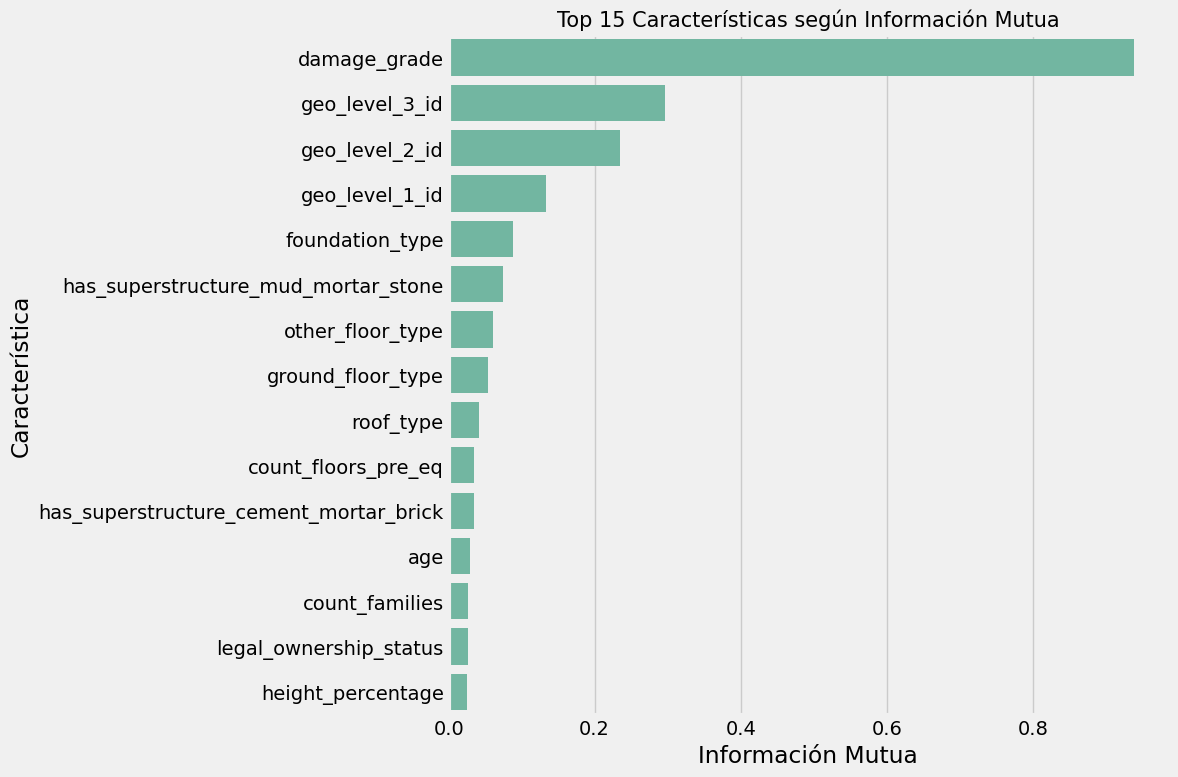


--- Selección basada en Importancia de Características (RandomForest) ---
Top 20 características según RandomForest:


,Característica,Importancia
38,damage_grade,0.88
0,geo_level_1_id,0.02
8,foundation_type,0.01
15,has_superstructure_mud_mortar_stone,0.01
9,roof_type,0.01
1,geo_level_2_id,0.01
4,age,0.01
10,ground_floor_type,0.01
2,geo_level_3_id,0.01
19,has_superstructure_cement_mortar_brick,0.01


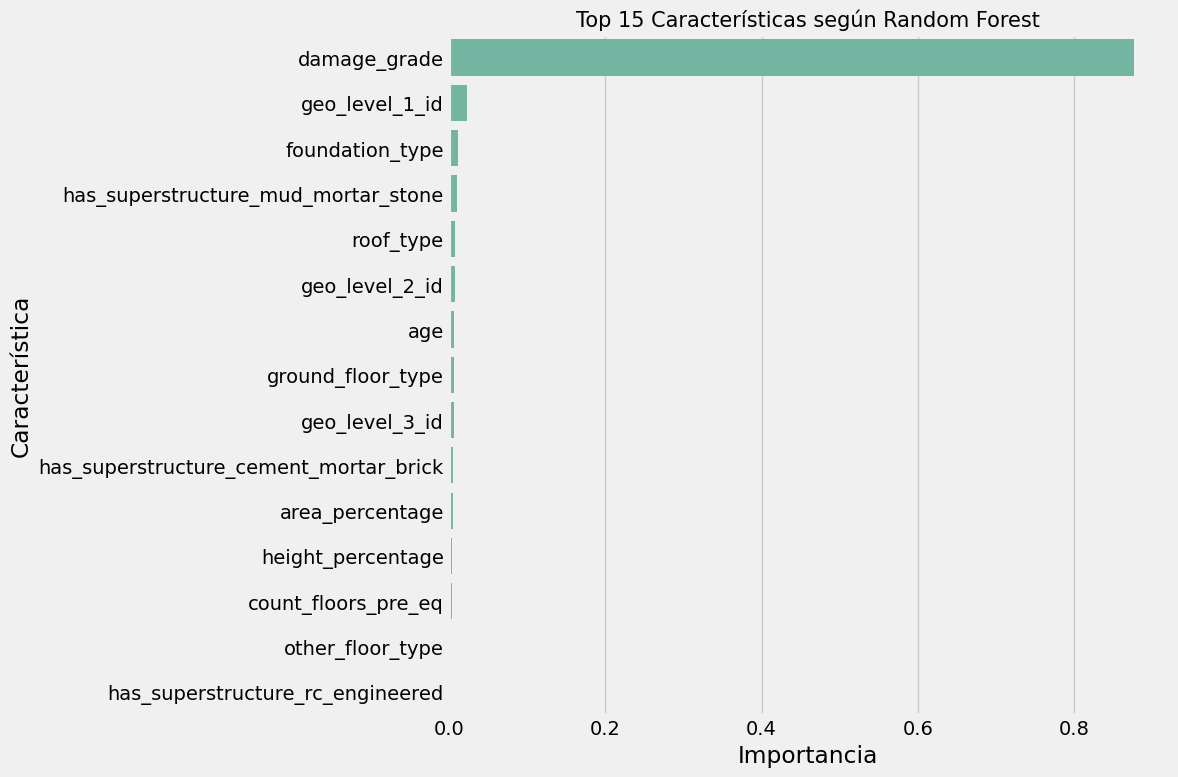


Características seleccionadas automáticamente por RandomForest (threshold='mean'): 1
['damage_grade']

--- Análisis de Componentes Principales ---
Número de componentes necesarios para explicar 95% de la varianza: 34


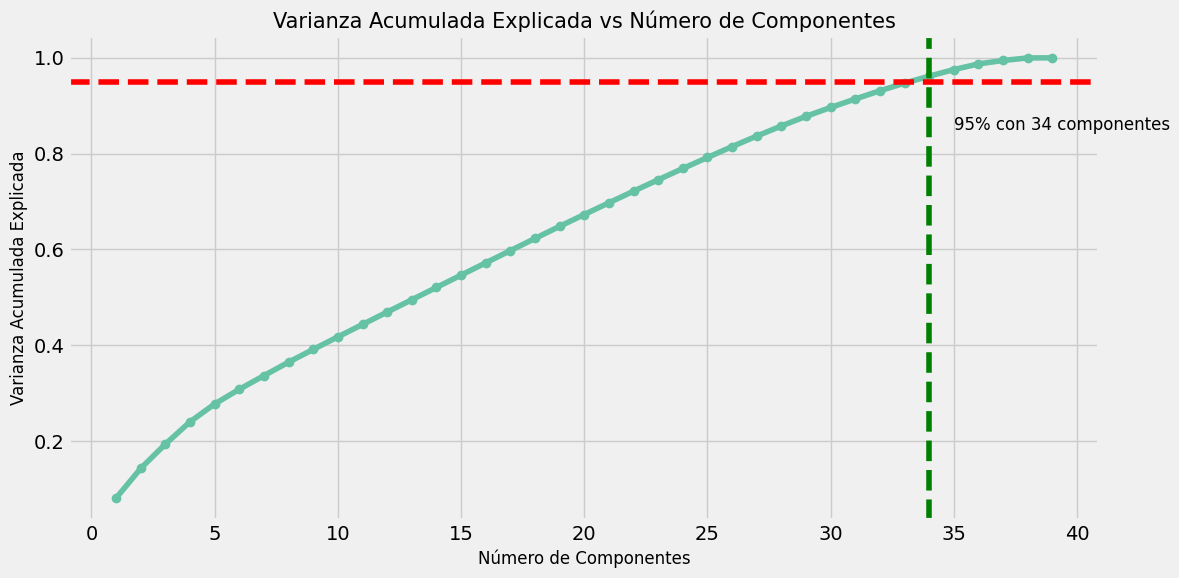


--- Características comunes entre métodos de selección ---
Características comunes en ANOVA y MI: 11
Características comunes en ANOVA y RF: 13
Características comunes en MI y RF: 17
Características comunes en los tres métodos: 10
Características comunes en los tres métodos:
['area_percentage', 'count_floors_pre_eq', 'damage_grade', 'foundation_type', 'geo_level_1_id', 'ground_floor_type', 'has_superstructure_cement_mortar_brick', 'has_superstructure_mud_mortar_stone', 'has_superstructure_rc_engineered', 'roof_type']

--- Selección final de características ---
Total de características seleccionadas: 21
Lista final de características seleccionadas:
['age', 'area_percentage', 'count_families', 'count_floors_pre_eq', 'damage_grade', 'foundation_type', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'ground_floor_type', 'has_superstructure_adobe_mud', 'has_superstructure_cement_mortar_brick', 'has_superstructure_mud_mortar_brick', 'has_superstructure_mud_mortar_stone', 'has_superstru

In [ ]:
print("===== SELECCIÓN DE CARACTERÍSTICAS ADICIONAL =====")

# 1. Preparación de datos para selección de características
# Convertimos características categóricas a numéricas para análisis estadísticos
X_encoded = convert_categorical_to_numeric(train_data, categorical_cols)
X_encoded = X_encoded.drop(['building_id'], axis=1)
y = train_data['damage_grade']

# 2. Método 1: Análisis univariante usando prueba F (ANOVA F-test)
print("\n--- Selección basada en prueba F (ANOVA) ---")
k_best_features = 20  # Seleccionamos top 20 características
selector_f = SelectKBest(f_classif, k=k_best_features)
X_kbest = selector_f.fit_transform(X_encoded, y)

# Obtener puntuaciones y nombres de las características seleccionadas
feature_scores = pd.DataFrame({
    'Característica': X_encoded.columns,
    'Puntuación F': selector_f.scores_,
    'P-valor': selector_f.pvalues_
})

# Ordenar por puntuación descendente y mostrar top 20
top_features_f = feature_scores.sort_values('Puntuación F', ascending=False).head(20)
print("Top 20 características según prueba F:")
display(top_features_f)

# Visualización de las principales características según ANOVA
plt.figure(figsize=(12, 8))
sns.barplot(x='Puntuación F', y='Característica', data=top_features_f.head(15))
plt.title('Top 15 Características según Prueba F (ANOVA)', fontsize=15)
plt.tight_layout()
plt.show()

# 3. Método 2: Información Mutua (captura relaciones no lineales)
print("\n--- Selección basada en Información Mutua ---")
selector_mi = SelectKBest(mutual_info_classif, k=k_best_features)
X_mi = selector_mi.fit_transform(X_encoded, y)

# Obtener puntuaciones
feature_scores_mi = pd.DataFrame({
    'Característica': X_encoded.columns,
    'Información Mutua': selector_mi.scores_
})

# Ordenar por puntuación descendente y mostrar top 20
top_features_mi = feature_scores_mi.sort_values('Información Mutua', ascending=False).head(20)
print("Top 20 características según Información Mutua:")
display(top_features_mi)

# Visualización de las principales características según Información Mutua
plt.figure(figsize=(12, 8))
sns.barplot(x='Información Mutua', y='Característica', data=top_features_mi.head(15))
plt.title('Top 15 Características según Información Mutua', fontsize=15)
plt.tight_layout()
plt.show()

# 4. Método 3: Importancia de características con RandomForest
print("\n--- Selección basada en Importancia de Características (RandomForest) ---")
feature_selector_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
feature_selector_rf.fit(X_encoded, y)

# Obtener importancias
feature_importances = pd.DataFrame({
    'Característica': X_encoded.columns,
    'Importancia': feature_selector_rf.feature_importances_
})

# Ordenar por importancia descendente y mostrar top 20
top_features_rf = feature_importances.sort_values('Importancia', ascending=False).head(20)
print("Top 20 características según RandomForest:")
display(top_features_rf)

# Visualización de las principales características según RandomForest
plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Característica', data=top_features_rf.head(15))
plt.title('Top 15 Características según Random Forest', fontsize=15)
plt.tight_layout()
plt.show()

# 5. Selección automática de características basada en umbral de importancia
selector_model = SelectFromModel(feature_selector_rf, threshold='mean')
X_important = selector_model.fit_transform(X_encoded, y)
selected_features_mask = selector_model.get_support()
selected_features = X_encoded.columns[selected_features_mask]

print(f"\nCaracterísticas seleccionadas automáticamente por RandomForest (threshold='mean'): {len(selected_features)}")
print(sorted(selected_features))

# 6. Análisis de Componentes Principales (PCA)
print("\n--- Análisis de Componentes Principales ---")
pca = PCA()
X_pca = pca.fit_transform(StandardScaler().fit_transform(X_encoded))

# Varianza explicada acumulada
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Determinar número de componentes para explicar al menos 95% de la varianza
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Número de componentes necesarios para explicar 95% de la varianza: {n_components_95}")

# Visualización de la varianza explicada
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=n_components_95, color='g', linestyle='--')
plt.text(n_components_95+1, 0.85, f'95% con {n_components_95} componentes', fontsize=12)
plt.title('Varianza Acumulada Explicada vs Número de Componentes', fontsize=15)
plt.xlabel('Número de Componentes', fontsize=12)
plt.ylabel('Varianza Acumulada Explicada', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Análisis final y compilación de selección de características

# Características que aparecen en al menos dos métodos (ANOVA, MI, RF)
common_features_anova_mi = set(top_features_f['Característica']).intersection(set(top_features_mi['Característica']))
common_features_anova_rf = set(top_features_f['Característica']).intersection(set(top_features_rf['Característica']))
common_features_mi_rf = set(top_features_mi['Característica']).intersection(set(top_features_rf['Característica']))

# Características que aparecen en los tres métodos
common_features_all = common_features_anova_mi.intersection(set(top_features_rf['Característica']))

print("\n--- Características comunes entre métodos de selección ---")
print(f"Características comunes en ANOVA y MI: {len(common_features_anova_mi)}")
print(f"Características comunes en ANOVA y RF: {len(common_features_anova_rf)}")
print(f"Características comunes en MI y RF: {len(common_features_mi_rf)}")
print(f"Características comunes en los tres métodos: {len(common_features_all)}")
print("Características comunes en los tres métodos:")
print(sorted(common_features_all))

# 8. Selección final de características basada en múltiples métodos

# Combinamos las características seleccionadas por diferentes métodos
# Incluimos todas las que aparecen en al menos dos métodos más las sugeridas por el dendrograma
selected_features_from_dendogram = selected_features  # Las que ya teníamos del dendrograma
selected_features_from_statistical = list(common_features_anova_mi.union(common_features_anova_rf, common_features_mi_rf))

# Características finales
final_selected_features = list(set(selected_features_from_dendogram).union(set(selected_features_from_statistical)))

print("\n--- Selección final de características ---")
print(f"Total de características seleccionadas: {len(final_selected_features)}")
print("Lista final de características seleccionadas:")
print(sorted(final_selected_features))

# Actualizar la lista de características seleccionadas para el modelado
selected_features = final_selected_features

# **Parte 5: Preprocesamiento de Datos y Selección de Muestra**


En esta sección, se preparan los datos para el modelado mediante preprocesamiento y muestreo estratificado.

## **1. Separación de Características y Variable Objetivo**
- Se eliminan las columnas `building_id` y `damage_grade` del conjunto de datos.
- Se identifican columnas **numéricas** y **categóricas** para su posterior procesamiento.

## **2. Estrategia de Selección de Muestra**
- Se aplica un **muestreo estratificado** para mantener la distribución de clases.
- Se agrupan los datos por niveles geográficos (`geo_level_1_id`, `geo_level_2_id`).
- Se selecciona un subconjunto representativo de **20,000 edificios** considerando características estructurales.

## **3. División en Conjuntos de Entrenamiento y Prueba**
- Se divide el subconjunto en **80% entrenamiento** y **20% prueba** utilizando `train_test_split`.
- Se garantiza que la distribución de la variable objetivo se mantenga equilibrada con `stratify`.

## **4. Preprocesamiento de Datos**
- Se aplica un `ColumnTransformer` para:
  - **Estandarizar** las características numéricas (`StandardScaler`).
  - **Codificar** las características categóricas (`OneHotEncoder`).
- Se transforman los datos de entrenamiento y prueba.

## **5. Almacenamiento del Preprocesador**
- Se guarda el preprocesador (`preprocessor.pkl`) para aplicarlo a nuevos datos en futuras predicciones.

Este preprocesamiento garantiza que los datos estén correctamente normalizados y preparados para el entrenamiento de modelos.

Estrategia de selección de muestra:
- Realizaremos un muestreo estratificado para mantener la distribución de clases
- Utilizaremos una selección basada en características geográficas para diversificar la muestra
- Seleccionaremos edificios con diferentes características estructurales
Muestra final: 19879 edificios


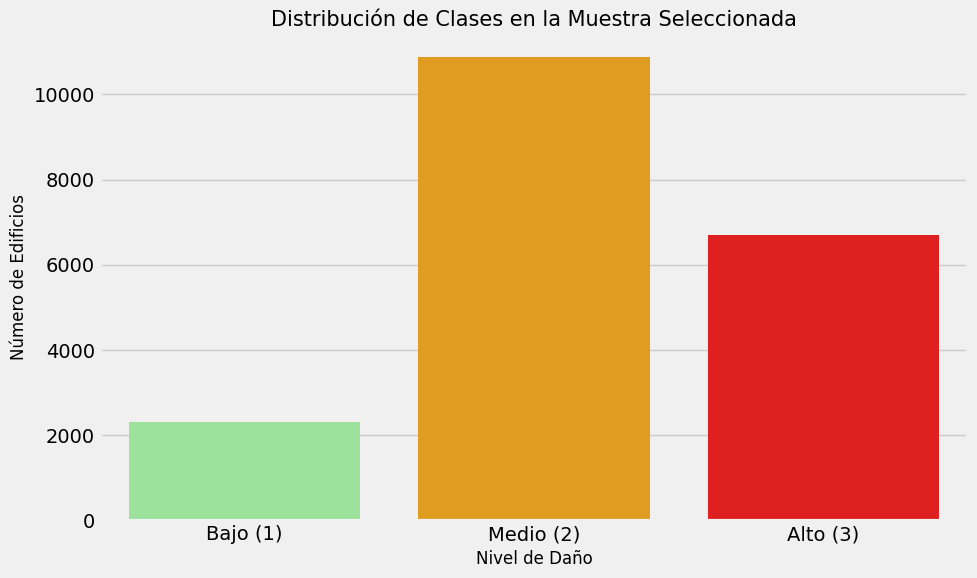

Tamaño conjunto entrenamiento: 15903 muestras
Tamaño conjunto prueba: 3976 muestras


In [ ]:
# Preprocesamiento de datos
X = train_data.drop(['building_id', 'damage_grade'], axis=1)
y = train_data['damage_grade']

# Identificar tipos de características
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Justificación para la selección de la muestra
print("Estrategia de selección de muestra:")
print("- Realizaremos un muestreo estratificado para mantener la distribución de clases")
print("- Utilizaremos una selección basada en características geográficas para diversificar la muestra")
print("- Seleccionaremos edificios con diferentes características estructurales")

# Selección de muestra justificada (no aleatoria)
# Agrupamos por niveles geográficos y tomamos un subconjunto representativo

def advanced_sampling(df, y, sample_size=20000):
    """
    Función para realizar un muestreo estratificado pero determinístico
    basado en características importantes del dominio
    """
    # Aseguramos que tengamos representación de diferentes regiones geográficas
    geo_groups = df.groupby(['geo_level_1_id', 'geo_level_2_id'])

    # Inicializar el DataFrame para la muestra
    sampled_indices = []

    # Para cada grupo geográfico, seleccionamos ejemplos representativos
    for name, group in geo_groups:
        # Determinamos cuántas muestras tomar de este grupo (proporcional a su tamaño)
        group_size = len(group)
        group_sample_size = max(1, int(group_size / len(df) * sample_size))

        # Estratificamos por nivel de daño dentro de cada grupo geográfico
        for damage_level in [1, 2, 3]:
            damage_indices = group[y == damage_level].index
            if len(damage_indices) > 0:
                # Tomamos un número proporcional de cada nivel de daño
                damage_ratio = sum(y[group.index] == damage_level) / group_size
                damage_sample_size = max(1, int(group_sample_size * damage_ratio))

                # Seleccionamos índices de forma determinística (no aleatoria)
                # Usamos características como edad y número de pisos para ordenar
                sorted_indices = df.loc[damage_indices].sort_values(
                    by=['age', 'count_floors_pre_eq', 'area_percentage']
                ).index[:damage_sample_size]

                sampled_indices.extend(sorted_indices)

    # Si no alcanzamos el tamaño deseado, completamos con más muestras
    if len(sampled_indices) < sample_size:
        remaining = sample_size - len(sampled_indices)
        # Seleccionamos más edificios basados en otras características
        additional_indices = df.sort_values(
            by=['foundation_type', 'roof_type', 'height_percentage']
        ).index[:remaining]
        sampled_indices.extend([idx for idx in additional_indices if idx not in sampled_indices])

    # Limitamos al tamaño deseado
    sampled_indices = sampled_indices[:sample_size]

    print(f"Muestra final: {len(sampled_indices)} edificios")

    return df.loc[sampled_indices], y.loc[sampled_indices]

# Seleccionamos un subconjunto manejable de datos
X_sampled, y_sampled = advanced_sampling(X, y, sample_size=20000)

# Verificamos la distribución de clases en la muestra
plt.figure(figsize=(10, 6))
sns.countplot(x=y_sampled, palette=['lightgreen', 'orange', 'red'])
plt.title('Distribución de Clases en la Muestra Seleccionada', fontsize=15)
plt.xlabel('Nivel de Daño', fontsize=12)
plt.ylabel('Número de Edificios', fontsize=12)
plt.xticks([0, 1, 2], ['Bajo (1)', 'Medio (2)', 'Alto (3)'])
plt.tight_layout()
plt.show()

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled
)

print(f"Tamaño conjunto entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño conjunto prueba: {X_test.shape[0]} muestras")

# Definimos el preprocesador para manejar columnas numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Preprocesamos los datos
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Guardamos el preprocesador para usarlo más tarde con los datos de prueba
import pickle
with open('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

# **Parte 6: Comparación Rápida de Modelos con LazyPredict**


En esta sección se utilizan múltiples algoritmos de clasificación para comparar su rendimiento de manera rápida y automatizada.

## **1. Evaluación con LazyPredict**
- Se utiliza `LazyClassifier` para probar distintos modelos de machine learning sin necesidad de configuraciones manuales.
- Se entrena y evalúa cada modelo con los datos preprocesados (`X_train_processed`, `X_test_processed`).
- Se almacenan las métricas de rendimiento de cada modelo.

## **2. Visualización de Resultados**
- Se ordenan y grafican los **15 mejores modelos** según:
  - **Precisión (Accuracy)**: Proporción de predicciones correctas.
  - **F1-Score**: Métrica que equilibra precisión y recall, priorizando modelos con mejor desempeño en clasificación multiclase.

## **3. Selección de Modelos para Optimización**
Basado en los resultados obtenidos, se seleccionan los **4 mejores modelos** para su posterior ajuste:
1. **LGBMClassifier (LightGBM)** – Modelo basado en boosting con alta eficiencia.
2. **BaggingClassifier** – Ensamble de modelos para reducir la varianza.
3. **RandomForestClassifier** – Modelo basado en múltiples árboles de decisión.
4. **SVC (Support Vector Classifier)** – Algoritmo de clasificación basado en hiperplanos.

Esta comparación inicial permite identificar los modelos más prometedores antes de realizar ajustes más avanzados.

 84%|████████▍ | 27/32 [01:47<00:42,  8.45s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 15903, number of used features: 58
[LightGBM] [Info] Start training from score -2.147545
[LightGBM] [Info] Start training from score -0.604105
[LightGBM] [Info] Start training from score -1.088664


100%|██████████| 32/32 [01:48<00:00,  3.39s/it]

Comparación de modelos con LazyPredict:


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.71,0.62,None,0.70,0.51
BaggingClassifier,0.69,0.60,None,0.68,1.89
RandomForestClassifier,0.68,0.59,None,0.67,3.85
DecisionTreeClassifier,0.62,0.56,None,0.62,0.33
BernoulliNB,0.46,0.56,None,0.43,0.11
NearestCentroid,0.42,0.55,None,0.35,0.10
ExtraTreesClassifier,0.64,0.55,None,0.63,3.42
GaussianNB,0.38,0.53,None,0.25,0.10
KNeighborsClassifier,0.58,0.51,None,0.57,0.43


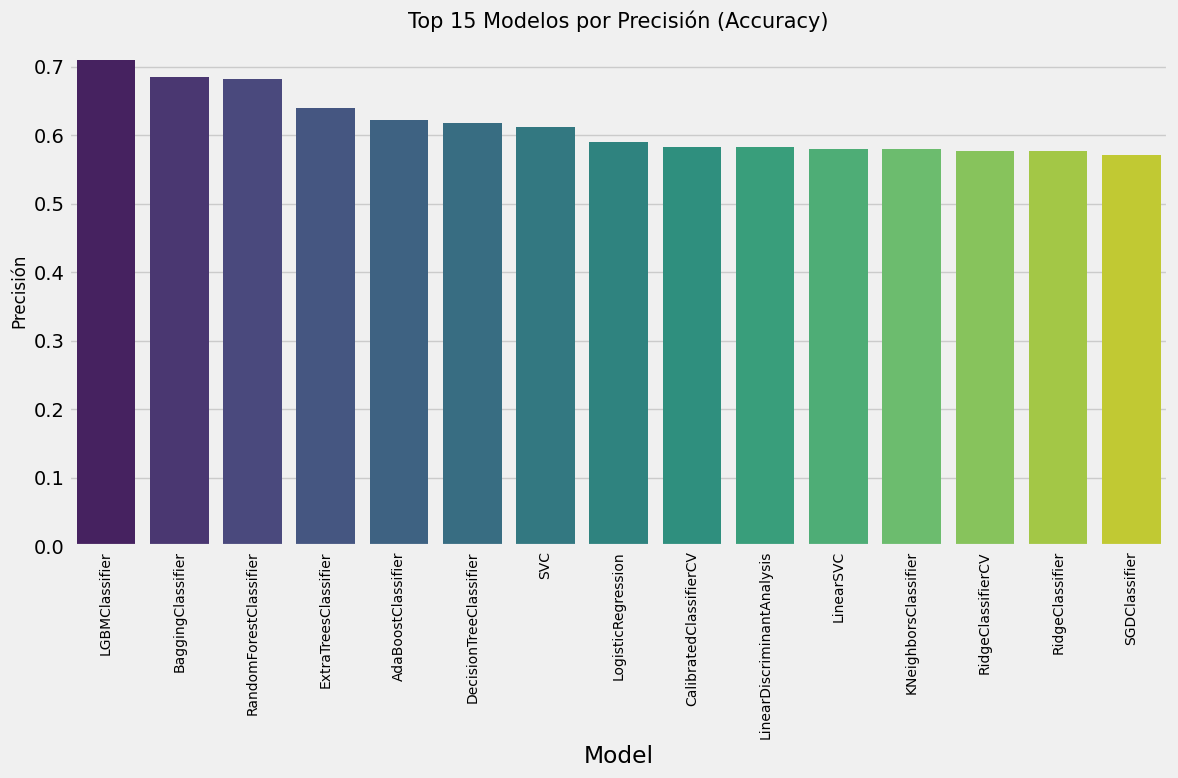

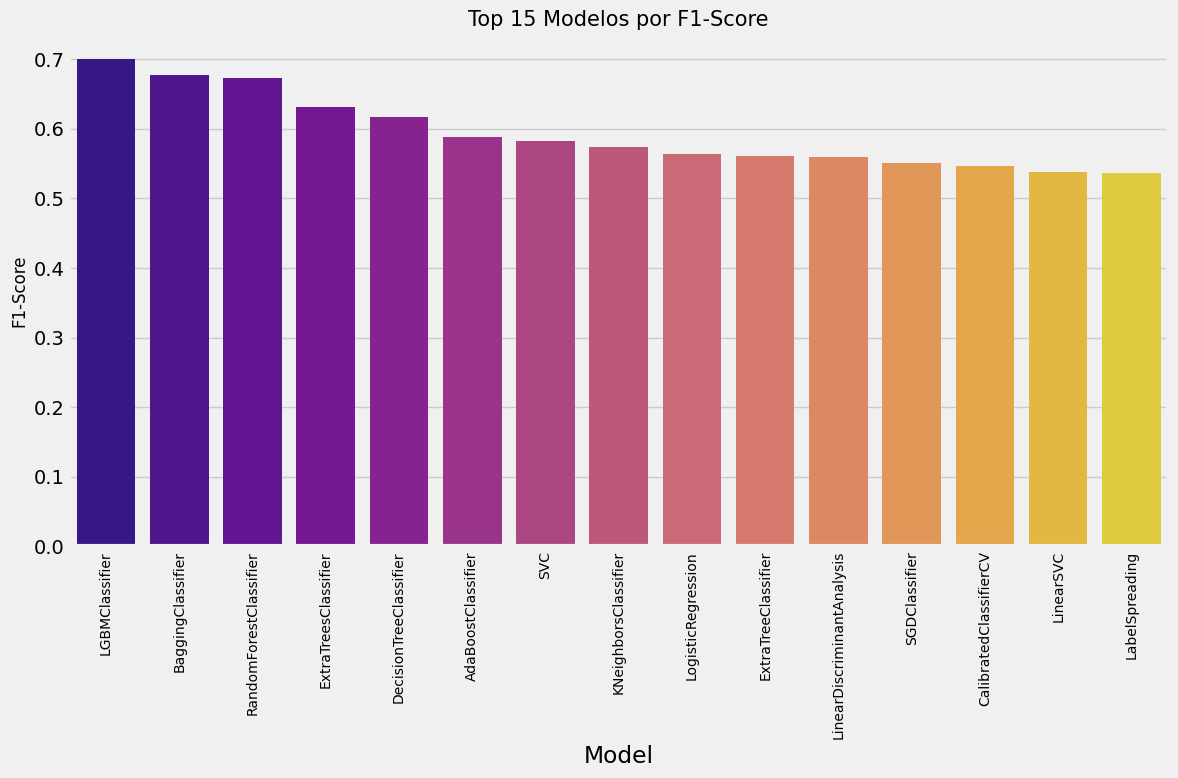

Basado en los resultados de LazyPredict, implementaremos los siguientes modelos:
1. LGBMClassifier (Light Gradient Boosting Machine)
2. BaggingClassifier
3. RandomForestClassifier
4. SVC (Support Vector Classifier)


In [ ]:
# Ejecutamos LazyPredict para comparar múltiples modelos rápidamente
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_processed, X_test_processed, y_train, y_test)

# Mostramos los resultados de todos los modelos
print("Comparación de modelos con LazyPredict:")
display(models)

# Visualización de los resultados
plt.figure(figsize=(12, 8))
models_accuracy = models.sort_values(by='Accuracy', ascending=False)[:15]
sns.barplot(x=models_accuracy.index, y=models_accuracy['Accuracy'], palette='viridis')
plt.title('Top 15 Modelos por Precisión (Accuracy)', fontsize=15)
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('Precisión', fontsize=12)
plt.tight_layout()
plt.show()

# También analizamos el F1-score, que es nuestra métrica principal
plt.figure(figsize=(12, 8))
models_f1 = models.sort_values(by='F1 Score', ascending=False)[:15]
sns.barplot(x=models_f1.index, y=models_f1['F1 Score'], palette='plasma')
plt.title('Top 15 Modelos por F1-Score', fontsize=15)
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('F1-Score', fontsize=12)
plt.tight_layout()
plt.show()

print("Basado en los resultados de LazyPredict, implementaremos los siguientes modelos:")
print("1. LGBMClassifier (Light Gradient Boosting Machine)")
print("2. BaggingClassifier")
print("3. RandomForestClassifier")
print("4. SVC (Support Vector Classifier)")

# **Parte 7: Implementación y optimización del modelo LGBMClassifier**


En esta sección se ajusta el modelo **LightGBM (LGBMClassifier)** utilizando búsqueda aleatoria de hiperparámetros y validación cruzada.

## **1. Definición del Modelo y Espacio de Hiperparámetros**
- Se configuran múltiples combinaciones de parámetros con RandomizedSearch como:
  - **Número de árboles**, **profundidad**, **tasa de aprendizaje** y **regularización**.
- Se generan **30 combinaciones aleatorias** (`ParameterSampler`).

## **2. Optimización con Validación Cruzada**
- Se usa **Stratified K-Fold (3 pliegues)** para evaluar cada combinación.
- Se calcula **precisión (`accuracy`) y F1-score** para seleccionar el mejor modelo.
- Se guarda la mejor configuración de parámetros.

## **3. Entrenamiento del Modelo Óptimo**
- Se entrena el **mejor modelo** encontrado con todo el conjunto de entrenamiento.

## **4. Evaluación del Modelo en Datos de Prueba**
- Se calculan **Accuracy y F1-score por clase**.
- Se grafica la **matriz de confusión** para analizar errores de clasificación.

## **5. Análisis de Rendimiento del Modelo**
- Se genera la **curva de aprendizaje** para evaluar el impacto de la tasa de aprendizaje (`learning_rate`).
- Se visualiza la **importancia de características** para interpretar qué variables afectan más la predicción.

## **6. Almacenamiento del Modelo**
- Se guarda el modelo entrenado como `lgbm_model_high_precision.pkl` para uso futuro.

Este proceso garantiza que el modelo LGBMClassifier esté optimizado para obtener la mejor precisión en la predicción del nivel de daño en edificios.

Iniciando optimización para máxima precisión general...


Optimizando LGBMClassifier para precisión:   3%|▎         | 1/30 [00:10<05:08, 10.62s/it]


Nuevo récord de precisión: 0.6997 con parámetros:
  subsample: 0.8
  reg_lambda: 0.0
  reg_alpha: 0.0
  num_leaves: 31
  n_estimators: 1000
  min_split_gain: 0.0
  min_child_samples: 20
  max_depth: 11
  learning_rate: 0.1
  colsample_bytree: 0.8
  boosting: gbdt
F1-score asociado: 0.6997


Optimizando LGBMClassifier para precisión:  20%|██        | 6/30 [01:08<04:45, 11.90s/it]


Nuevo récord de precisión: 0.7070 con parámetros:
  subsample: 0.9
  reg_lambda: 0.0
  reg_alpha: 0.0
  num_leaves: 63
  n_estimators: 500
  min_split_gain: 0.01
  min_child_samples: 20
  max_depth: 7
  learning_rate: 0.05
  colsample_bytree: 0.8
  boosting: gbdt
F1-score asociado: 0.7070


Optimizando LGBMClassifier para precisión:  47%|████▋     | 14/30 [03:12<04:30, 16.88s/it]


Nuevo récord de precisión: 0.7070 con parámetros:
  subsample: 0.8
  reg_lambda: 0.0
  reg_alpha: 1.0
  num_leaves: 127
  n_estimators: 500
  min_split_gain: 0.01
  min_child_samples: 50
  max_depth: 9
  learning_rate: 0.1
  colsample_bytree: 0.8
  boosting: dart
F1-score asociado: 0.7070


Optimizando LGBMClassifier para precisión: 100%|██████████| 30/30 [08:25<00:00, 16.85s/it]


Nuevo récord de precisión: 0.7073 con parámetros:
  subsample: 1.0
  reg_lambda: 1.0
  reg_alpha: 0.0
  num_leaves: 127
  n_estimators: 300
  min_split_gain: 0.01
  min_child_samples: 20
  max_depth: 9
  learning_rate: 0.05
  colsample_bytree: 0.9
  boosting: gbdt
F1-score asociado: 0.7073

Entrenando modelo final con los mejores parámetros...



Entrenamiento completo.
Mejores parámetros para máxima precisión: {'verbose': -1, 'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.0, 'num_leaves': 127, 'n_estimators': 300, 'min_split_gain': 0.01, 'min_child_samples': 20, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.9, 'boosting': 'gbdt'}
Mejor accuracy en validación cruzada: 0.7073

Resultados en conjunto de prueba:
Accuracy: 0.7206
F1-score (micro): 0.7206
F1-score por clase: Clase 1: 0.5013, Clase 2: 0.7758, Clase 3: 0.6845


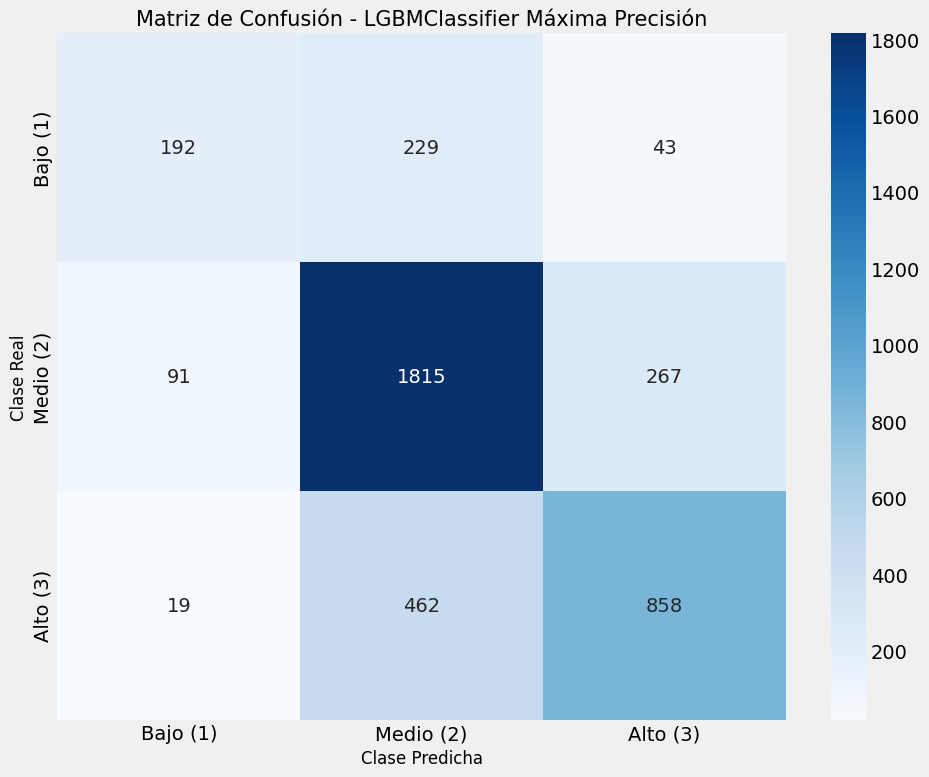


Informe de clasificación - LGBMClassifier Optimizado para Precisión:
              precision    recall  f1-score   support

           1       0.64      0.41      0.50       464
           2       0.72      0.84      0.78      2173
           3       0.73      0.64      0.68      1339

    accuracy                           0.72      3976
   macro avg       0.70      0.63      0.65      3976
weighted avg       0.72      0.72      0.71      3976



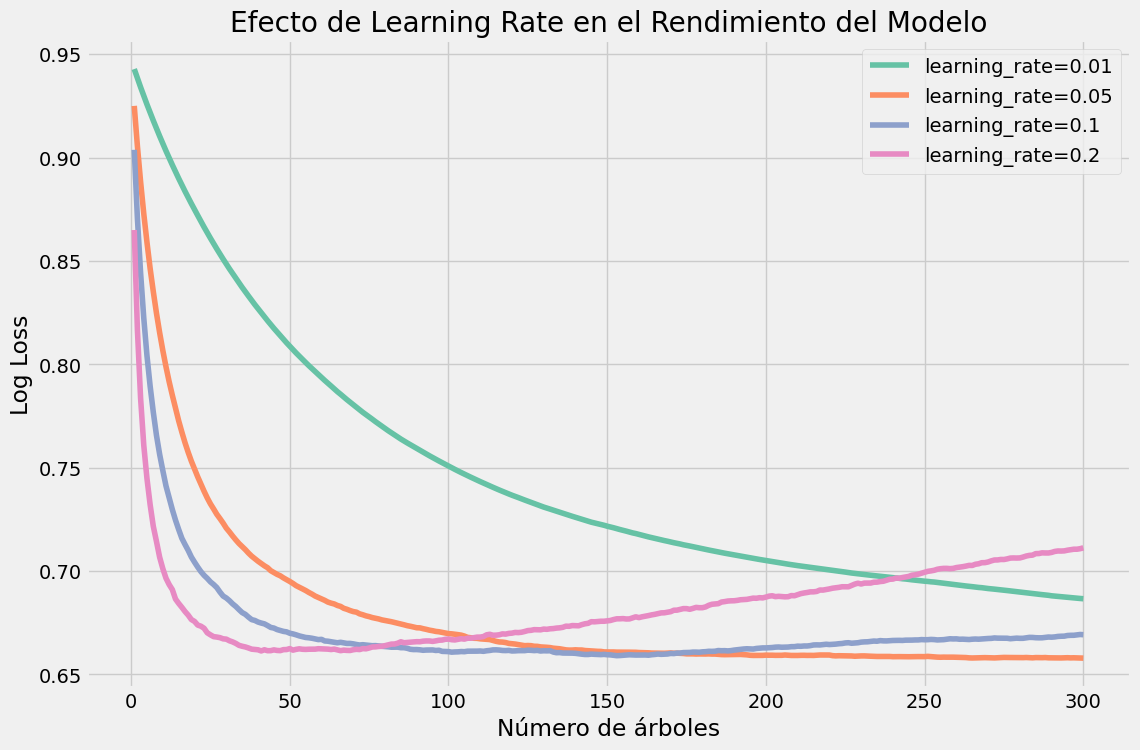

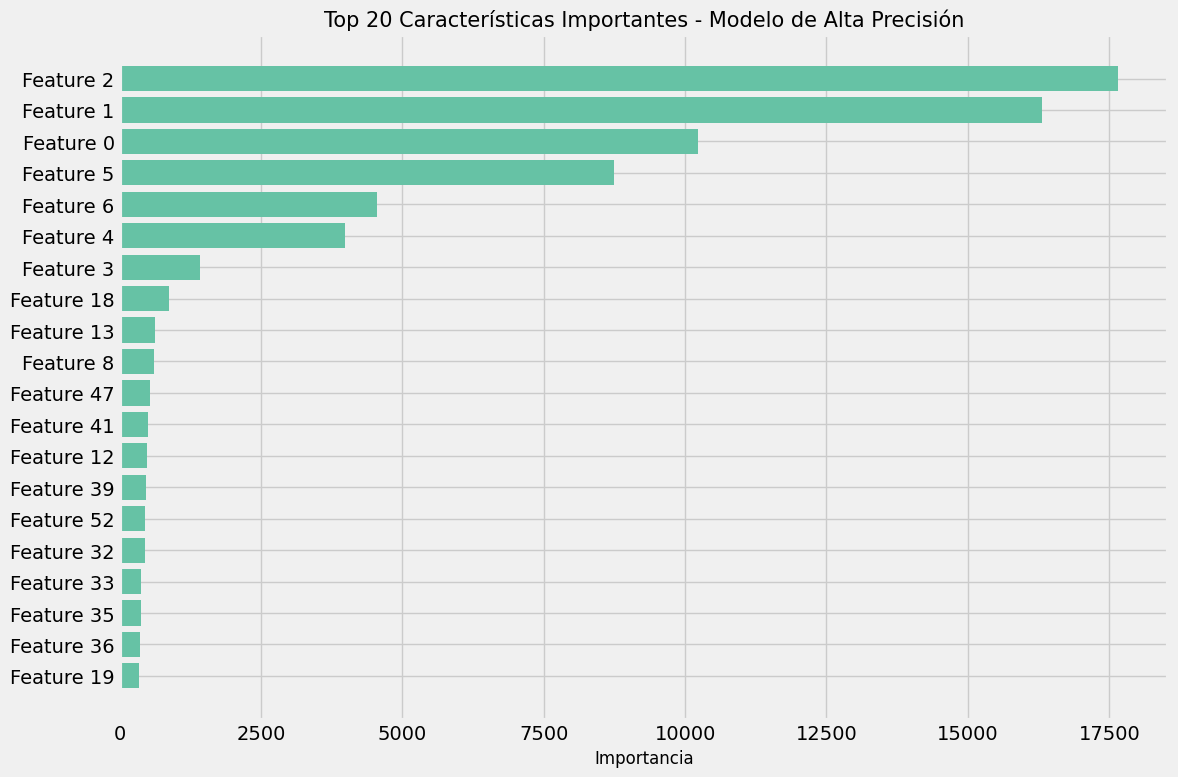

In [ ]:
# Modelo 1: LGBMClassifier optimizado para máxima precisión general
# Configuración inicial con enfoque en alta precisión general
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1)

# Espacio de parámetros enfocado en precisión general
param_dist_lgbm = {
    'n_estimators': [300, 500, 700, 1000],  # Más árboles para mayor estabilidad
    'learning_rate': [0.01, 0.05, 0.1],  # Tasas de aprendizaje variadas
    'max_depth': [7, 9, 11],  # Profundidades moderadas
    'num_leaves': [31, 63, 127],  # Diferentes configuraciones de hojas
    'min_child_samples': [20, 50, 100],  # Valores más altos para evitar overfitting
    'subsample': [0.8, 0.9, 1.0],  # Incluir muestreo completo
    'colsample_bytree': [0.8, 0.9, 1.0],  # Opciones de muestreo de características
    'min_split_gain': [0.0, 0.01],  # Valores para controlar divisiones
    'reg_alpha': [0.0, 0.1, 1.0],  # Regularización L1 más fuerte
    'reg_lambda': [0.0, 0.1, 1.0],  # Regularización L2 más fuerte
    'boosting': ['gbdt', 'dart'],  # Probar diferentes algoritmos de boosting
    'verbose': [-1]
}

# Más iteraciones para explorar mejor el espacio de parámetros
param_list = list(ParameterSampler(param_dist_lgbm, n_iter=30, random_state=42))

# Inicializar para tracking
best_accuracy = 0
best_params = None
results = []

# Configurar validación cruzada
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("Iniciando optimización para máxima precisión general...")
for params in tqdm(param_list, desc="Optimizando LGBMClassifier para precisión"):
    model = LGBMClassifier(random_state=42, n_jobs=-1, **params)
    accuracies = []
    f1_scores = []

    # Validación cruzada manual
    for train_idx, val_idx in cv.split(X_train_processed, y_train):
        if isinstance(X_train_processed, np.ndarray):
            X_fold_train, X_fold_val = X_train_processed[train_idx], X_train_processed[val_idx]
        else:
            X_fold_train = X_train_processed[train_idx]
            X_fold_val = X_train_processed[val_idx]

        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]

        # Entrenar y evaluar con énfasis en precisión general
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)

        # Métricas enfocadas en precisión general
        acc = accuracy_score(y_fold_val, y_pred)
        f1 = f1_score(y_fold_val, y_pred, average='micro')

        accuracies.append(acc)
        f1_scores.append(f1)

    # Usar accuracy como métrica principal
    mean_accuracy = np.mean(accuracies)
    mean_f1 = np.mean(f1_scores)

    results.append((params, mean_accuracy, mean_f1))

    # Actualizar el mejor modelo basado en accuracy
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_params = params
        print(f"\nNuevo récord de precisión: {best_accuracy:.4f} con parámetros:")
        for key, value in params.items():
            if key != 'verbose':  # Omitir parámetros no relevantes
                print(f"  {key}: {value}")
        print(f"F1-score asociado: {mean_f1:.4f}")

# Crear el mejor modelo con los parámetros óptimos
best_lgbm = LGBMClassifier(random_state=42, n_jobs=-1, **best_params)

# Entrenar con todo el conjunto de entrenamiento
print("\nEntrenando modelo final con los mejores parámetros...")
best_lgbm.fit(X_train_processed, y_train)

print("\nEntrenamiento completo.")
print(f"Mejores parámetros para máxima precisión: {best_params}")
print(f"Mejor accuracy en validación cruzada: {best_accuracy:.4f}")

# Evaluar en conjunto de prueba
y_pred_lgbm = best_lgbm.predict(X_test_processed)

# Métricas detalladas
accuracy = accuracy_score(y_test, y_pred_lgbm)
lgbm_f1 = f1_score(y_test, y_pred_lgbm, average='micro')
lgbm_f1_per_class = f1_score(y_test, y_pred_lgbm, average=None)

print(f"\nResultados en conjunto de prueba:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score (micro): {lgbm_f1:.4f}")
print(f"F1-score por clase: Clase 1: {lgbm_f1_per_class[0]:.4f}, Clase 2: {lgbm_f1_per_class[1]:.4f}, Clase 3: {lgbm_f1_per_class[2]:.4f}")

# Matriz de confusión con enfoque en precisión total
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'],
            yticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'])
plt.title('Matriz de Confusión - LGBMClassifier Máxima Precisión', fontsize=15)
plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.tight_layout()
plt.show()

# Clasificación detallada
print("\nInforme de clasificación - LGBMClassifier Optimizado para Precisión:")
print(classification_report(y_test, y_pred_lgbm))

# Curva de aprendizaje para análisis adicional
if 'n_estimators' in best_params:
    n_estimators = best_params['n_estimators']
    learning_rates = [0.01, 0.05, 0.1, 0.2]

    plt.figure(figsize=(12, 8))
    for lr in learning_rates:
        eval_set = [(X_test_processed, y_test)]
        model = LGBMClassifier(
            n_estimators=n_estimators,
            learning_rate=lr,
            random_state=42,
            n_jobs=-1,
            verbose=-1  # Colocar verbose aquí en la inicialización, no en fit()
        )
        model.fit(X_train_processed, y_train,
                 eval_set=eval_set,
                 eval_metric='multi_logloss')  # Sin verbose aquí

        results = model.evals_result_['valid_0']['multi_logloss']
        plt.plot(range(1, len(results) + 1), results, label=f'learning_rate={lr}')

    plt.xlabel('Número de árboles')
    plt.ylabel('Log Loss')
    plt.title('Efecto de Learning Rate en el Rendimiento del Modelo')
    plt.legend()
    plt.grid(True)
    plt.show()

# Importancia de características para entender el modelo
plt.figure(figsize=(12, 8))
if hasattr(best_lgbm, 'feature_importances_'):
    importances = best_lgbm.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 características
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
    plt.title('Top 20 Características Importantes - Modelo de Alta Precisión', fontsize=15)
    plt.xlabel('Importancia', fontsize=12)
    plt.tight_layout()
    plt.show()

# Guardar el modelo de alta precisión
with open('lgbm_model_high_precision.pkl', 'wb') as file:
    pickle.dump(best_lgbm, file)

# **Parte 8: Implementación y optimización del modelo BaggingClassifier**

En esta sección, se optimiza el modelo **BaggingClassifier** utilizando **búsqueda aleatoria de hiperparámetros** y validación cruzada.

## **1. Definición del Modelo y Espacio de Hiperparámetros**
- Se define un **árbol de decisión (`DecisionTreeClassifier`)** como estimador base.
- Se configuran hiperparámetros para:
  - **Número de estimadores**, **muestras y características por bootstrap**, **profundidad del árbol** y **criterios de división**.
- Se generan **20 combinaciones aleatorias** (`ParameterSampler`).

## **2. Optimización con Validación Cruzada**
- Se utiliza **Stratified K-Fold (3 pliegues)** para evaluar cada combinación de parámetros.
- Se separan los parámetros específicos del **árbol de decisión** (`estimator__`) y del **BaggingClassifier**.
- Se calcula el **F1-score promedio** en validación cruzada y se selecciona la mejor combinación.

## **3. Entrenamiento del Modelo Óptimo**
- Se crea el modelo **BaggingClassifier** con los mejores hiperparámetros encontrados.
- Se entrena con todo el conjunto de entrenamiento.

## **4. Evaluación del Modelo en Datos de Prueba**
- Se calculan **Accuracy y F1-score**.
- Se grafica la **matriz de confusión** para analizar errores de clasificación.

## **5. Almacenamiento del Modelo**
- Se guarda el modelo entrenado como `bagging_model.pkl` para uso futuro.

Este proceso garantiza que el modelo **BaggingClassifier** esté optimizado para mejorar la estabilidad y reducir la varianza en la predicción del nivel de daño en edificios.

Iniciando optimización para BaggingClassifier con visualización de progreso...


Optimizando BaggingClassifier:   5%|▌         | 1/20 [00:02<00:53,  2.82s/it]


Nuevo mejor F1-score: 0.6265 con parámetros:
  n_estimators: 10
  max_samples: 1.0
  max_features: 1.0
  estimator__min_samples_split: 2
  estimator__min_samples_leaf: 2
  estimator__max_depth: 20
  bootstrap: False


Optimizando BaggingClassifier:  15%|█▌        | 3/20 [00:09<00:50,  2.95s/it]


Nuevo mejor F1-score: 0.6845 con parámetros:
  n_estimators: 100
  max_samples: 1.0
  max_features: 0.5
  estimator__min_samples_split: 2
  estimator__min_samples_leaf: 4
  estimator__max_depth: 10
  bootstrap: True


Optimizando BaggingClassifier:  30%|███       | 6/20 [00:14<00:28,  2.06s/it]


Nuevo mejor F1-score: 0.7004 con parámetros:
  n_estimators: 100
  max_samples: 0.5
  max_features: 1.0
  estimator__min_samples_split: 5
  estimator__min_samples_leaf: 2
  estimator__max_depth: 20
  bootstrap: True


Optimizando BaggingClassifier:  60%|██████    | 12/20 [00:26<00:17,  2.17s/it]


Nuevo mejor F1-score: 0.7040 con parámetros:
  n_estimators: 100
  max_samples: 1.0
  max_features: 0.5
  estimator__min_samples_split: 5
  estimator__min_samples_leaf: 1
  estimator__max_depth: 20
  bootstrap: False


Optimizando BaggingClassifier: 100%|██████████| 20/20 [00:37<00:00,  1.86s/it]



Entrenamiento completo.
Mejores parámetros para BaggingClassifier:
Parámetros del estimador base:
  min_samples_split: 5
  min_samples_leaf: 1
  max_depth: 20
Parámetros de Bagging:
  n_estimators: 100
  max_samples: 1.0
  max_features: 0.5
  bootstrap: False
Mejor F1-score en validación cruzada: 0.7040
F1-score (micro) en conjunto de prueba: 0.7153


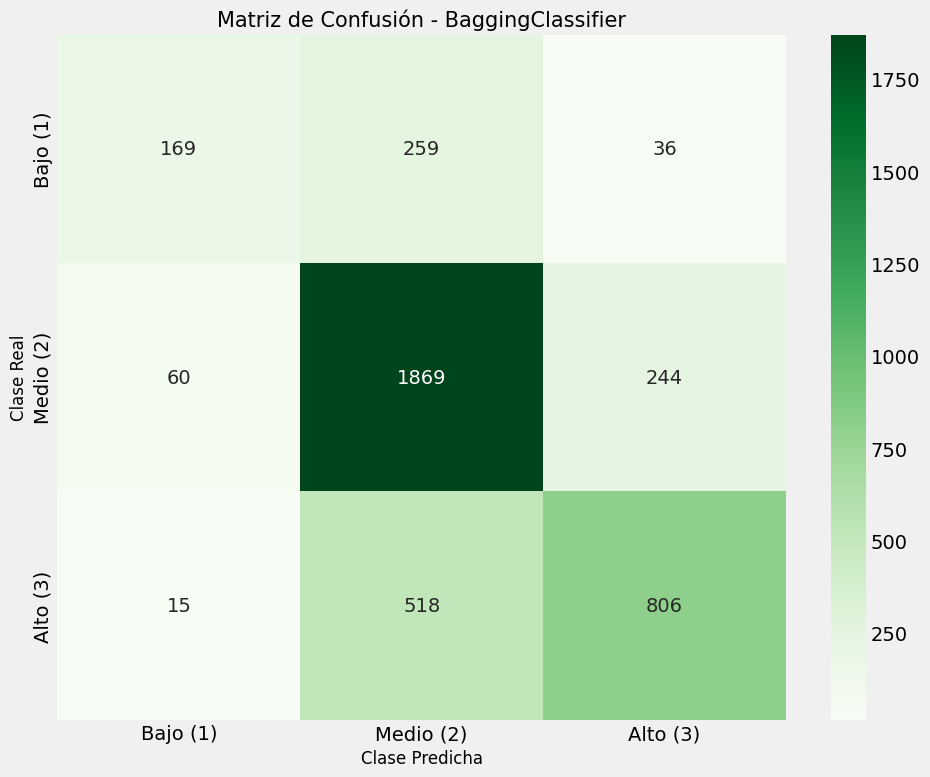

Informe de clasificación - BaggingClassifier:
              precision    recall  f1-score   support

           1       0.69      0.36      0.48       464
           2       0.71      0.86      0.78      2173
           3       0.74      0.60      0.66      1339

    accuracy                           0.72      3976
   macro avg       0.71      0.61      0.64      3976
weighted avg       0.72      0.72      0.70      3976



In [ ]:
# Modelo 2: BaggingClassifier con visualización de progreso (tqdm)
# Configuración inicial
base_estimator = DecisionTreeClassifier(random_state=42)
bagging_model = BaggingClassifier(estimator=base_estimator, random_state=42, n_jobs=-1)

# Definir parámetros para búsqueda
param_dist_bagging = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

# Genera combinaciones aleatorias de parámetros
param_list = list(ParameterSampler(param_dist_bagging, n_iter=20, random_state=42))

# Inicializa listas para almacenar resultados
best_score = 0
best_params = None
results = []

# Configura validación cruzada
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Bucle con barra de progreso
print("Iniciando optimización para BaggingClassifier con visualización de progreso...")
for params in tqdm(param_list, desc="Optimizando BaggingClassifier"):
    # Separar los parámetros del estimador base de los parámetros de BaggingClassifier
    estimator_params = {}
    bagging_params = {}

    for key, value in params.items():
        if key.startswith('estimator__'):
            # Extraer el nombre del parámetro sin el prefijo
            param_name = key.replace('estimator__', '')
            estimator_params[param_name] = value
        else:
            bagging_params[key] = value

    # Crear el estimador base con sus parámetros
    base_est = DecisionTreeClassifier(random_state=42, **estimator_params)

    # Crear el modelo BaggingClassifier
    model = BaggingClassifier(estimator=base_est, random_state=42, n_jobs=-1, **bagging_params)

    scores = []

    # Validación cruzada manual
    for train_idx, val_idx in cv.split(X_train_processed, y_train):
        # Extraer los datos para este pliegue
        if isinstance(X_train_processed, np.ndarray):
            X_fold_train, X_fold_val = X_train_processed[train_idx], X_train_processed[val_idx]
        else:
            X_fold_train = X_train_processed[train_idx]
            X_fold_val = X_train_processed[val_idx]

        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]

        # Entrenar y evaluar el modelo
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        score = f1_score(y_fold_val, y_pred, average='micro')
        scores.append(score)

    # Calcular promedio
    mean_score = np.mean(scores)
    results.append((params, mean_score))

    # Actualizar mejor modelo si es necesario
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        print(f"\nNuevo mejor F1-score: {best_score:.4f} con parámetros:")
        for key, value in params.items():
            print(f"  {key}: {value}")

# Crear el mejor modelo con los parámetros óptimos
# Separar los parámetros del mejor modelo
estimator_params = {}
bagging_params = {}

for key, value in best_params.items():
    if key.startswith('estimator__'):
        param_name = key.replace('estimator__', '')
        estimator_params[param_name] = value
    else:
        bagging_params[key] = value

# Crear el estimador base final
best_base_estimator = DecisionTreeClassifier(random_state=42, **estimator_params)

# Crear el modelo final
best_bagging = BaggingClassifier(
    estimator=best_base_estimator,
    random_state=42,
    n_jobs=-1,
    **bagging_params
)
best_bagging.fit(X_train_processed, y_train)

print("\nEntrenamiento completo.")
print(f"Mejores parámetros para BaggingClassifier:")
print("Parámetros del estimador base:")
for key, value in estimator_params.items():
    print(f"  {key}: {value}")
print("Parámetros de Bagging:")
for key, value in bagging_params.items():
    print(f"  {key}: {value}")
print(f"Mejor F1-score en validación cruzada: {best_score:.4f}")

# Evaluar el modelo optimizado
y_pred_bagging = best_bagging.predict(X_test_processed)

# Métricas de evaluación
bagging_f1 = f1_score(y_test, y_pred_bagging, average='micro')
print(f"F1-score (micro) en conjunto de prueba: {bagging_f1:.4f}")

# Matriz de confusión
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred_bagging)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'],
            yticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'])
plt.title('Matriz de Confusión - BaggingClassifier', fontsize=15)
plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.tight_layout()
plt.show()

# Clasificación detallada
print("Informe de clasificación - BaggingClassifier:")
print(classification_report(y_test, y_pred_bagging))

# Guardar el modelo
with open('bagging_model.pkl', 'wb') as file:
    pickle.dump(best_bagging, file)

# **Parte 9: Implementación y optimización del modelo RandomForestClassifier**

En esta sección se optimiza el modelo **Random Forest** mediante búsqueda aleatoria de hiperparámetros y validación cruzada.

## **1. Definición del Modelo y Espacio de Hiperparámetros**
- Se establecen combinaciones para:
  - **Número de estimadores (`n_estimators`)**.
  - **Profundidad máxima del árbol (`max_depth`)**.
  - **Mínimo de muestras por división (`min_samples_split`)**.
  - **Muestras mínimas en hojas (`min_samples_leaf`)**.
  - **Número de características por árbol (`max_features`)**.

## **2. Optimización con Validación Cruzada**
- Se generan **20 combinaciones aleatorias** de hiperparámetros (`ParameterSampler`).
- Se aplica **Stratified K-Fold (3 pliegues)** para evaluar cada configuración.
- Se selecciona el modelo con el mejor **F1-score promedio**.

## **3. Entrenamiento del Modelo Óptimo**
- Se entrena el **mejor Random Forest** con los parámetros óptimos encontrados.

## **4. Evaluación del Modelo en Datos de Prueba**
- Se calculan métricas de desempeño, incluyendo **F1-score**.
- Se grafica la **matriz de confusión** para analizar errores de clasificación.

## **5. Importancia de Características**
- Se identifican y visualizan las **20 características más importantes** utilizadas por el modelo.

## **6. Almacenamiento del Modelo**
- Se guarda el modelo entrenado como `random_forest_model.pkl` para uso futuro.

Este proceso permite optimizar **RandomForestClassifier** para lograr un mejor balance entre precisión y generalización en la predicción del nivel de daño en edificios.


Iniciando optimización para RandomForestClassifier con visualización de progreso...


Optimizando RandomForest:   5%|▌         | 1/20 [00:00<00:15,  1.24it/s]


Nuevo mejor F1-score: 0.6740 con parámetros:
  n_estimators: 100
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: log2
  max_depth: 30


Optimizando RandomForest:  15%|█▌        | 3/20 [00:02<00:12,  1.31it/s]


Nuevo mejor F1-score: 0.6750 con parámetros:
  n_estimators: 100
  min_samples_split: 5
  min_samples_leaf: 1
  max_features: log2
  max_depth: 20


Optimizando RandomForest:  20%|██        | 4/20 [00:03<00:12,  1.29it/s]


Nuevo mejor F1-score: 0.6806 con parámetros:
  n_estimators: 100
  min_samples_split: 10
  min_samples_leaf: 2
  max_features: sqrt
  max_depth: 30


Optimizando RandomForest:  25%|██▌       | 5/20 [00:03<00:11,  1.29it/s]


Nuevo mejor F1-score: 0.6811 con parámetros:
  n_estimators: 100
  min_samples_split: 10
  min_samples_leaf: 2
  max_features: sqrt
  max_depth: None


Optimizando RandomForest:  70%|███████   | 14/20 [00:15<00:06,  1.14s/it]


Nuevo mejor F1-score: 0.6814 con parámetros:
  n_estimators: 100
  min_samples_split: 2
  min_samples_leaf: 2
  max_features: sqrt
  max_depth: None


Optimizando RandomForest:  80%|████████  | 16/20 [00:19<00:06,  1.55s/it]


Nuevo mejor F1-score: 0.6819 con parámetros:
  n_estimators: 300
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: sqrt
  max_depth: 30


Optimizando RandomForest:  85%|████████▌ | 17/20 [00:20<00:04,  1.57s/it]


Nuevo mejor F1-score: 0.6824 con parámetros:
  n_estimators: 200
  min_samples_split: 2
  min_samples_leaf: 2
  max_features: sqrt
  max_depth: 30


Optimizando RandomForest: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]



Entrenamiento completo.
Mejores parámetros para RandomForestClassifier: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30}
Mejor F1-score en validación cruzada: 0.6824
F1-score (micro) en conjunto de prueba: 0.6861


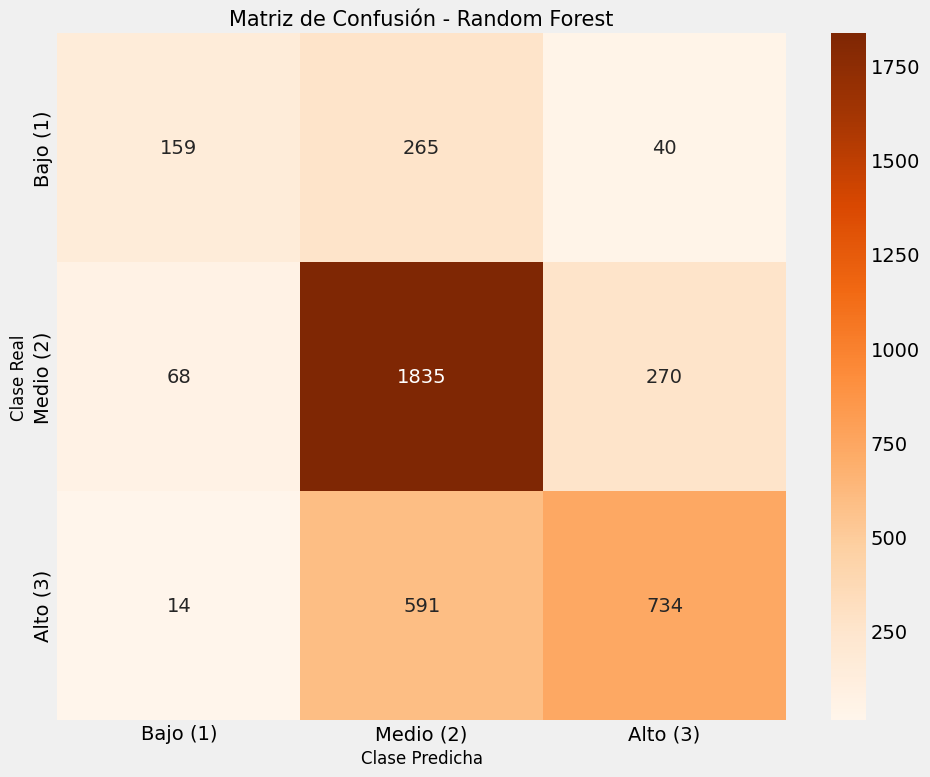

Informe de clasificación - Random Forest:
              precision    recall  f1-score   support

           1       0.66      0.34      0.45       464
           2       0.68      0.84      0.75      2173
           3       0.70      0.55      0.62      1339

    accuracy                           0.69      3976
   macro avg       0.68      0.58      0.61      3976
weighted avg       0.69      0.69      0.67      3976



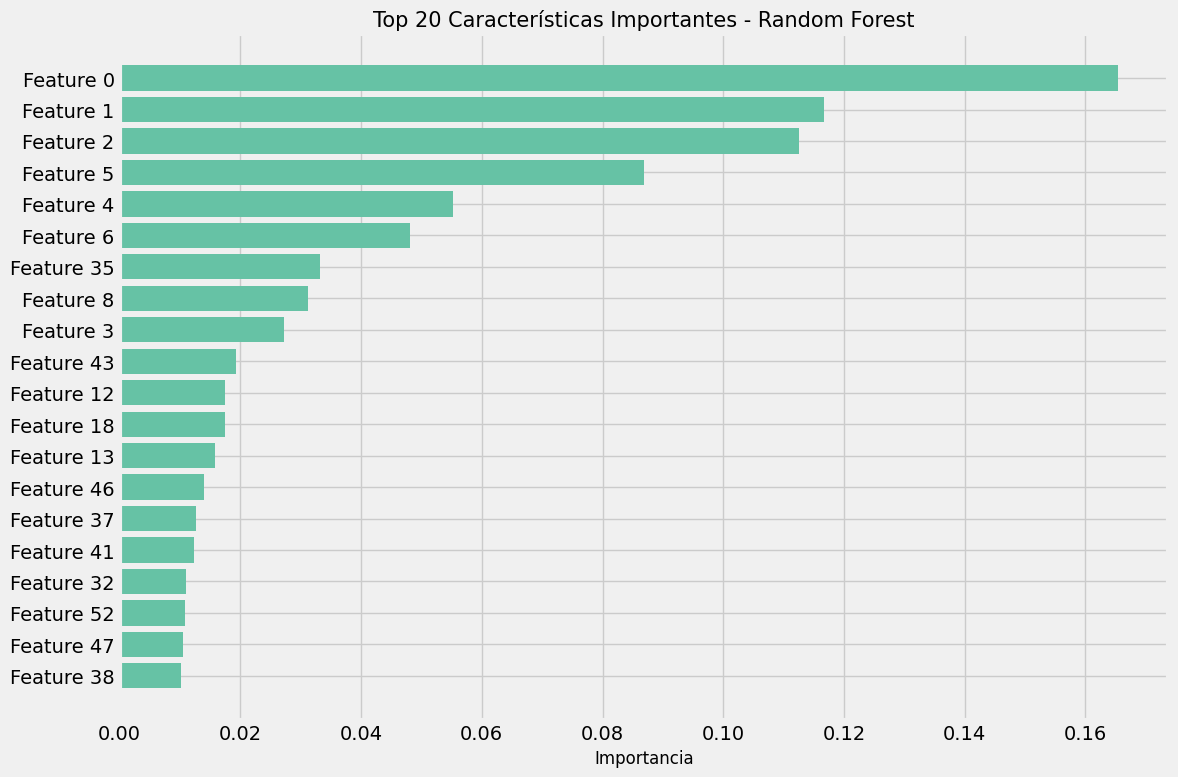

In [ ]:
# Modelo 3: RandomForestClassifier con visualización de progreso (tqdm)
# Configuración inicial
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Definir parámetros para búsqueda
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  # Eliminado 'auto', que ya no es válido
}

# Genera combinaciones aleatorias de parámetros
param_list = list(ParameterSampler(param_dist_rf, n_iter=20, random_state=42))

# Inicializa listas para almacenar resultados
best_score = 0
best_params = None
results = []

# Configura validación cruzada
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Bucle con barra de progreso
print("Iniciando optimización para RandomForestClassifier con visualización de progreso...")
for params in tqdm(param_list, desc="Optimizando RandomForest"):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
    scores = []

    # Validación cruzada manual
    for train_idx, val_idx in cv.split(X_train_processed, y_train):
        # Extraer los datos para este pliegue
        if isinstance(X_train_processed, np.ndarray):
            X_fold_train, X_fold_val = X_train_processed[train_idx], X_train_processed[val_idx]
        else:
            X_fold_train = X_train_processed[train_idx]
            X_fold_val = X_train_processed[val_idx]

        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]

        # Entrenar y evaluar el modelo
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        score = f1_score(y_fold_val, y_pred, average='micro')
        scores.append(score)

    # Calcular promedio
    mean_score = np.mean(scores)
    results.append((params, mean_score))

    # Actualizar mejor modelo si es necesario
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        print(f"\nNuevo mejor F1-score: {best_score:.4f} con parámetros:")
        for key, value in params.items():
            print(f"  {key}: {value}")

# Crear el mejor modelo con los parámetros óptimos
best_rf = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params)
best_rf.fit(X_train_processed, y_train)

print("\nEntrenamiento completo.")
print(f"Mejores parámetros para RandomForestClassifier: {best_params}")
print(f"Mejor F1-score en validación cruzada: {best_score:.4f}")

# Evaluar el modelo optimizado
y_pred_rf = best_rf.predict(X_test_processed)

# Métricas de evaluación
rf_f1 = f1_score(y_test, y_pred_rf, average='micro')
print(f"F1-score (micro) en conjunto de prueba: {rf_f1:.4f}")

# Matriz de confusión
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'],
            yticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'])
plt.title('Matriz de Confusión - Random Forest', fontsize=15)
plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.tight_layout()
plt.show()

# Clasificación detallada
print("Informe de clasificación - Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Importancia de características
if hasattr(best_rf, 'feature_importances_'):
    # Visualización simplificada de importancias
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 características
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
    plt.title('Top 20 Características Importantes - Random Forest', fontsize=15)
    plt.xlabel('Importancia', fontsize=12)
    plt.tight_layout()
    plt.show()

# Guardar el modelo
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

# **Parte 10: Implementación y optimización del modelo SVC**


En esta sección se optimiza el modelo **SVM (Support Vector Classifier)** utilizando búsqueda aleatoria de hiperparámetros y validación cruzada.

## **1. Definición del Modelo y Espacio de Hiperparámetros**
- Se ajustan los siguientes parámetros:
  - **C**: Parámetro de regularización.
  - **Kernel**: Función del núcleo (`linear` o `rbf`).
  - **Gamma**: Influencia de cada punto de entrenamiento en el modelo (`scale`, `auto`, valores específicos).

## **2. Optimización con Validación Cruzada**
- Para acelerar el proceso, se usa un **subconjunto de 5000 muestras** si el conjunto de entrenamiento es muy grande.
- Se generan **10 combinaciones aleatorias** (`ParameterSampler`).
- Se aplica **Stratified K-Fold (3 pliegues)** para evaluar cada configuración.
- Se selecciona la combinación con el **mejor F1-score promedio**.

## **3. Entrenamiento del Modelo Óptimo**
- Se entrena el **mejor SVM** con los parámetros óptimos encontrados en el **conjunto completo**.

## **4. Evaluación del Modelo en Datos de Prueba**
- Se calculan métricas de desempeño, incluyendo **F1-score**.
- Se grafica la **matriz de confusión** para analizar errores de clasificación.

## **5. Almacenamiento del Modelo**
- Se guarda el modelo entrenado como `svm_model.pkl` para uso futuro.

Este proceso permite optimizar **SVM** para lograr una clasificación más precisa y eficiente del nivel de daño en edificios.

Usando subconjunto de 5000 muestras para entrenar SVM
Iniciando optimización para SVC con visualización de progreso...


Optimizando SVC:  10%|█         | 1/10 [00:08<01:20,  8.93s/it]


Nuevo mejor F1-score: 0.5592 con parámetros:
  kernel: linear
  gamma: scale
  C: 0.1


Optimizando SVC:  30%|███       | 3/10 [00:41<01:43, 14.80s/it]


Nuevo mejor F1-score: 0.5724 con parámetros:
  kernel: linear
  gamma: auto
  C: 1


Optimizando SVC:  60%|██████    | 6/10 [01:31<01:04, 16.07s/it]


Nuevo mejor F1-score: 0.5890 con parámetros:
  kernel: rbf
  gamma: scale
  C: 10


Optimizando SVC:  80%|████████  | 8/10 [02:52<00:53, 26.94s/it]


Nuevo mejor F1-score: 0.5970 con parámetros:
  kernel: rbf
  gamma: auto
  C: 10


Optimizando SVC:  90%|█████████ | 9/10 [03:09<00:23, 23.98s/it]


Nuevo mejor F1-score: 0.6020 con parámetros:
  kernel: rbf
  gamma: 0.1
  C: 1


Optimizando SVC: 100%|██████████| 10/10 [03:18<00:00, 19.81s/it]



Entrenando modelo SVC final con el conjunto completo...

Entrenamiento completo.
Mejores parámetros para SVC: {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
Mejor F1-score en validación cruzada: 0.6020
F1-score (micro) en conjunto de prueba: 0.6207


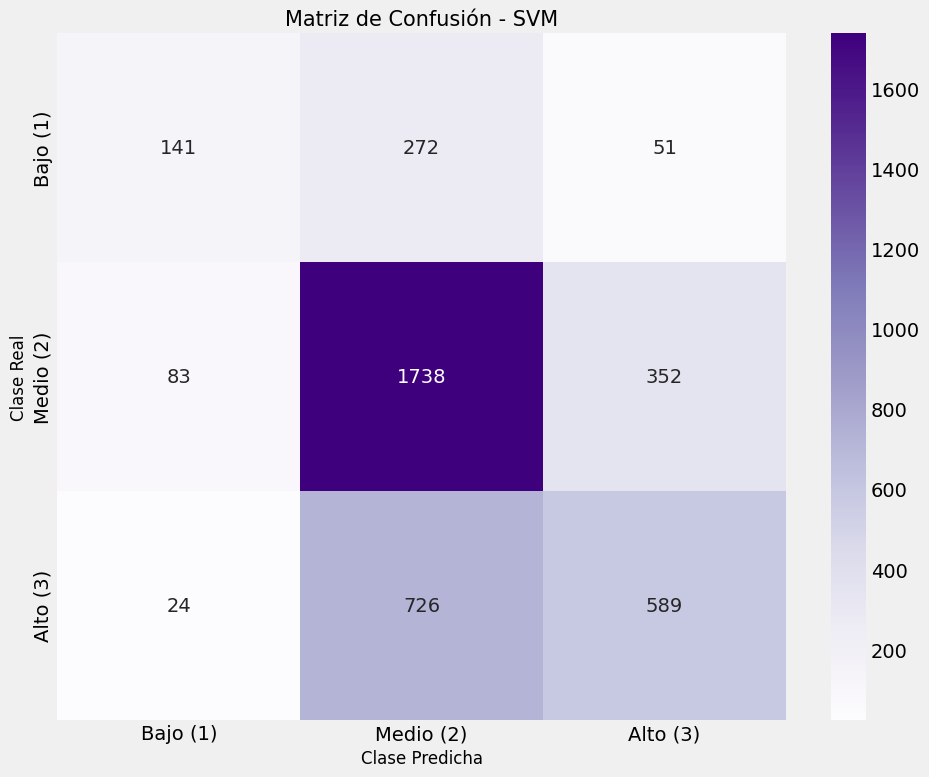

Informe de clasificación - SVM:
              precision    recall  f1-score   support

           1       0.57      0.30      0.40       464
           2       0.64      0.80      0.71      2173
           3       0.59      0.44      0.51      1339

    accuracy                           0.62      3976
   macro avg       0.60      0.51      0.54      3976
weighted avg       0.61      0.62      0.60      3976



In [ ]:
# Modelo 4: Support Vector Machine (SVM) con visualización de progreso (tqdm)
# Configuración inicial
svm_model = SVC(probability=True, random_state=42)

# Definir parámetros para búsqueda
param_dist_svm = {
    'C': [0.1, 1, 10],  # Parámetro de regularización
    'kernel': ['linear', 'rbf'],  # Kernel
    'gamma': ['scale', 'auto', 0.1]  # Coeficiente del kernel
}

# Para acelerar el entrenamiento con SVM, usamos una muestra reducida
if X_train_processed.shape[0] > 5000:
    from sklearn.model_selection import train_test_split
    X_train_svm, _, y_train_svm, _ = train_test_split(
        X_train_processed, y_train,
        train_size=5000,
        random_state=42,
        stratify=y_train
    )
    print(f"Usando subconjunto de {X_train_svm.shape[0]} muestras para entrenar SVM")
else:
    X_train_svm = X_train_processed
    y_train_svm = y_train

# Genera combinaciones aleatorias de parámetros
param_list = list(ParameterSampler(param_dist_svm, n_iter=10, random_state=42))

# Inicializa listas para almacenar resultados
best_score = 0
best_params = None
results = []

# Configura validación cruzada
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Bucle con barra de progreso
print("Iniciando optimización para SVC con visualización de progreso...")
for params in tqdm(param_list, desc="Optimizando SVC"):
    model = SVC(probability=True, random_state=42, **params)
    scores = []

    # Validación cruzada manual
    for train_idx, val_idx in cv.split(X_train_svm, y_train_svm):
        # Extraer los datos para este pliegue
        if isinstance(X_train_svm, np.ndarray):
            X_fold_train, X_fold_val = X_train_svm[train_idx], X_train_svm[val_idx]
        else:
            X_fold_train = X_train_svm[train_idx]
            X_fold_val = X_train_svm[val_idx]

        y_fold_train = y_train_svm.iloc[train_idx]
        y_fold_val = y_train_svm.iloc[val_idx]

        # Entrenar y evaluar el modelo
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        score = f1_score(y_fold_val, y_pred, average='micro')
        scores.append(score)

    # Calcular promedio
    mean_score = np.mean(scores)
    results.append((params, mean_score))

    # Actualizar mejor modelo si es necesario
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        print(f"\nNuevo mejor F1-score: {best_score:.4f} con parámetros:")
        for key, value in params.items():
            print(f"  {key}: {value}")

# Crear el mejor modelo con los parámetros óptimos y entrenarlo en el conjunto completo
best_svm = SVC(probability=True, random_state=42, **best_params)
print("\nEntrenando modelo SVC final con el conjunto completo...")
best_svm.fit(X_train_processed, y_train)

print("\nEntrenamiento completo.")
print(f"Mejores parámetros para SVC: {best_params}")
print(f"Mejor F1-score en validación cruzada: {best_score:.4f}")

# Evaluar el modelo optimizado en el conjunto de prueba completo
y_pred_svm = best_svm.predict(X_test_processed)

# Métricas de evaluación
svm_f1 = f1_score(y_test, y_pred_svm, average='micro')
print(f"F1-score (micro) en conjunto de prueba: {svm_f1:.4f}")

# Matriz de confusión
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'],
            yticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'])
plt.title('Matriz de Confusión - SVM', fontsize=15)
plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.tight_layout()
plt.show()

# Clasificación detallada
print("Informe de clasificación - SVM:")
print(classification_report(y_test, y_pred_svm))

# Guardar el modelo
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(best_svm, file)

# **Parte 11: Uso de GridSearch y Randomized para determinar la mejor búsqueda de hiperparámetros**

Esta sección implementa la optimización de hiperparámetros para el modelo **LGBMClassifier** utilizando **GridSearchCV** y **RandomizedSearchCV** con seguimiento detallado del progreso.

## **1. Preparación de Datos**
- Se identifican **características numéricas y categóricas**.
- Se configura un **preprocesador (`ColumnTransformer`)** que:
  - Estandariza los datos numéricos con `StandardScaler`.
  - Codifica variables categóricas con `OneHotEncoder`.

## **2. Definición de Estrategias de Búsqueda**
- **GridSearchCV**: Evalúa todas las combinaciones de parámetros en un espacio reducido.
- **RandomizedSearchCV**: Explora de forma aleatoria un mayor rango de hiperparámetros en menos iteraciones.

### **Espacio de búsqueda:**
- **Parámetros principales:** `n_estimators`, `learning_rate`, `num_leaves`, `max_depth`, `min_child_samples`, `subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda`.
- **Total de combinaciones calculadas**:
  - **GridSearchCV**: Se estima el número total de modelos a probar.
  - **RandomizedSearchCV**: Se limita a **10 iteraciones aleatorias** para reducir el tiempo de cómputo.

## **3. Implementación y Ejecución**
- Se dividen los datos en **80% entrenamiento y 20% prueba** (`train_test_split`).
- Se imprime información detallada sobre:
  - **Número de combinaciones a evaluar**.
  - **Tiempo estimado de ejecución**.
- Se configuran ambos métodos con `verbose=3` para un seguimiento detallado.

## **4. Evaluación de Resultados**
- Se obtienen los **mejores hiperparámetros** para cada estrategia.
- Se mide el desempeño en validación cruzada y en el conjunto de prueba mediante **F1-score**.
- Se comparan tiempos de ejecución para cada método.

## **5. Resumen Final**
- Se muestra un **resumen comparativo** entre **GridSearchCV** y **RandomizedSearchCV**.
- Se reportan los **valores óptimos** encontrados y el **tiempo total de ejecución**.

Esta optimización ayuda a seleccionar el mejor conjunto de hiperparámetros para mejorar el rendimiento del modelo de clasificación.

In [ ]:
# =====================================================================
# OPTIMIZACIÓN DE HIPERPARÁMETROS CON PROGRESO DETALLADO
# =====================================================================

print("=== OPTIMIZACIÓN DE HIPERPARÁMETROS CON SEGUIMIENTO DETALLADO ===")

# Preparación de datos
print("Preparando datos...")
X = train_data.drop(['building_id', 'damage_grade'], axis=1)
y = train_data['damage_grade']

# Identificación de columnas categóricas y numéricas
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if X[col].dtype != 'object']

print(f"Características numéricas: {len(numerical_cols)}")
print(f"Características categóricas: {len(categorical_cols)}")

# Preprocesador para datos mixtos
print("Configurando preprocesador...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

# Pipeline con LGBMClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42))
])

# Definir métricas de evaluación (F1-score)
scoring = make_scorer(f1_score, average='micro')

# Configuración de validación cruzada estratificada
cv_folds = 3
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"Configurando validación cruzada: {cv_folds}-fold estratificada")

# Reducir espacio de parámetros para pruebas más rápidas
param_grid = {
    'classifier__n_estimators': [200, 300],  # Reducido para prueba
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__num_leaves': [31, 63],
    'classifier__max_depth': [7, 9],
    'classifier__min_child_samples': [20],
    'classifier__subsample': [1.0],
    'classifier__colsample_bytree': [0.8, 0.9],
    'classifier__reg_alpha': [0.0],
    'classifier__reg_lambda': [0.0, 1.0]
}

# Calcular combinaciones totales para GridSearchCV
grid_combinations = 1
for param in param_grid.values():
    grid_combinations *= len(param)
total_grid_fits = grid_combinations * cv_folds

print(f"\n=== INFORMACIÓN DE BÚSQUEDA ===")
print(f"GridSearchCV: {grid_combinations} combinaciones × {cv_folds} folds = {total_grid_fits} modelos")

# Espacio de parámetros para RandomizedSearchCV (reducido pero variado)
param_dist = {
    'classifier__n_estimators': [200, 300, 400],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [31, 63, 127],
    'classifier__max_depth': [7, 9, 11, -1],
    'classifier__min_child_samples': [10, 20, 50],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],
    'classifier__reg_alpha': [0.0, 0.1, 0.5],
    'classifier__reg_lambda': [0.0, 0.5, 1.0]
}

# Configuración de RandomizedSearchCV
n_iter_search = 10  # Reducido para prueba
total_random_fits = n_iter_search * cv_folds
print(f"RandomizedSearchCV: {n_iter_search} iteraciones × {cv_folds} folds = {total_random_fits} modelos")

# División en conjuntos de entrenamiento y prueba para evaluación
print("\nDividiendo datos en conjuntos de entrenamiento y prueba (80/20)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

# 1. GRID SEARCH CV CON FEEDBACK DETALLADO
print("\n" + "="*80)
print("INICIANDO GRIDSEARCHCV CON VERBOSE DETALLADO")
print("="*80)
start_time_grid = time.time()

# Mostrar información de lo que se va a hacer
print("\nGridSearchCV procesará:")
print(f"- {X_train.shape[0]} muestras × {total_grid_fits} modelos")
print(f"- Parámetros a explorar: {len(param_grid)} dimensiones")
print(f"- Combinaciones totales: {grid_combinations}\n")

# Mostrar ETA basado en estimaciones
estimate_per_model = 0.5  # segundos por modelo (aproximado)
estimated_total_time = estimate_per_model * total_grid_fits
est_hours, remainder = divmod(estimated_total_time, 3600)
est_minutes, est_seconds = divmod(remainder, 60)
print(f"Tiempo estimado: {int(est_hours)} horas, {int(est_minutes)} minutos, {int(est_seconds)} segundos")
print("(Esta es una estimación aproximada basada en 0.5 segundos por modelo)\n")

# Crear y ejecutar GridSearchCV con verbose máximo
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=3  # Máximo nivel de verbose
)

print("Comenzando búsqueda con GridSearchCV...")
print("(Se mostrarán mensajes detallados del progreso)")
grid_search.fit(X_train, y_train)
grid_time = time.time() - start_time_grid

grid_min, grid_sec = divmod(int(grid_time), 60)
grid_hour, grid_min = divmod(grid_min, 60)
print(f"\nGridSearchCV completado en {grid_hour:02d}:{grid_min:02d}:{grid_sec:02d}")

# Evaluación en conjunto de prueba
print("\nEvaluando en conjunto de prueba...")
y_pred_grid = grid_search.predict(X_test)
lgbm_grid_f1 = f1_score(y_test, y_pred_grid, average='micro')

print(f"Mejor F1-score CV (GridSearchCV): {grid_search.best_score_:.4f}")
print(f"F1-score en test (GridSearchCV): {lgbm_grid_f1:.4f}")
print(f"Mejores parámetros (GridSearchCV):")
for param, value in grid_search.best_params_.items():
    # Simplificamos mostrando los parámetros sin manipular las cadenas
    param_name = param
    if param.startswith("classifier__"):
        param_name = param[11:]  # Eliminamos "classifier__" de forma manual
    print(f"  {param_name}: {value}")

# 2. RANDOMIZED SEARCH CV CON FEEDBACK DETALLADO
print("\n" + "="*80)
print("INICIANDO RANDOMIZEDSEARCHCV CON VERBOSE DETALLADO")
print("="*80)
start_time_random = time.time()

# Mostrar información de lo que se va a hacer
print("\nRandomizedSearchCV procesará:")
print(f"- {X_train.shape[0]} muestras × {total_random_fits} modelos")
print(f"- Espacio de búsqueda: {len(param_dist)} dimensiones")
print(f"- Iteraciones: {n_iter_search} de {np.prod([len(v) for v in param_dist.values()])} posibles\n")

# Mostrar parámetros de muestra para RandomizedSearchCV
sampled_params = list(ParameterSampler(param_dist, n_iter=3, random_state=42))
print("\nEjemplo de parámetros que se evaluarán:")
for i, params in enumerate(sampled_params):
    print(f"  Conjunto {i+1}:")
    for k, v in params.items():
        param_name = k
        if k.startswith("classifier__"):
            param_name = k[11:]  # Eliminamos "classifier__" de forma manual
        print(f"    {param_name} = {v}")

# Mostrar ETA basado en estimaciones
estimate_per_model_random = 0.5  # segundos por modelo (aproximado)
estimated_total_time_random = estimate_per_model_random * total_random_fits
est_hours_r, remainder_r = divmod(estimated_total_time_random, 3600)
est_minutes_r, est_seconds_r = divmod(remainder_r, 60)
print(f"\nTiempo estimado: {int(est_hours_r)} horas, {int(est_minutes_r)} minutos, {int(est_seconds_r)} segundos")
print("(Esta es una estimación aproximada basada en 0.5 segundos por modelo)\n")

# Crear y ejecutar RandomizedSearchCV con verbose máximo
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    random_state=42,
    verbose=3  # Máximo nivel de verbose
)

print("Comenzando búsqueda con RandomizedSearchCV...")
print("(Se mostrarán mensajes detallados del progreso)")
random_search.fit(X_train, y_train)
random_time = time.time() - start_time_random

random_min, random_sec = divmod(int(random_time), 60)
random_hour, random_min = divmod(random_min, 60)
print(f"\nRandomizedSearchCV completado en {random_hour:02d}:{random_min:02d}:{random_sec:02d}")

# Evaluación en conjunto de prueba
print("\nEvaluando en conjunto de prueba...")
y_pred_random = random_search.predict(X_test)
lgbm_randomized_f1 = f1_score(y_test, y_pred_random, average='micro')

print(f"Mejor F1-score CV (RandomizedSearchCV): {random_search.best_score_:.4f}")
print(f"F1-score en test (RandomizedSearchCV): {lgbm_randomized_f1:.4f}")
print(f"Mejores parámetros (RandomizedSearchCV):")
for param, value in random_search.best_params_.items():
    param_name = param
    if param.startswith("classifier__"):
        param_name = param[11:]
    print(f"  {param_name}: {value}")

# RESUMEN FINAL
print("\n" + "="*80)
print("RESUMEN FINAL DE OPTIMIZACIÓN")
print("="*80)
print(f"GridSearchCV: {lgbm_grid_f1:.4f} en {grid_hour:02d}:{grid_min:02d}:{grid_sec:02d}")
print(f"RandomizedSearchCV: {lgbm_randomized_f1:.4f} en {random_hour:02d}:{random_min:02d}:{random_sec:02d}")

print("\n=== VALORES PARA COMPARACIÓN DE MODELOS ===")
print(f"lgbm_grid_f1 = {lgbm_grid_f1:.4f}")
print(f"lgbm_randomized_f1 = {lgbm_randomized_f1:.4f}")

# Mostrar tiempo total de ejecución
total_time = grid_time + random_time
total_min, total_sec = divmod(int(total_time), 60)
total_hour, total_min = divmod(total_min, 60)
print(f"\nTiempo total de ejecución: {total_hour:02d}:{total_min:02d}:{total_sec:02d}")
print(f"Finalizado: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

=== OPTIMIZACIÓN DE HIPERPARÁMETROS CON SEGUIMIENTO DETALLADO ===
Inicio: 2025-03-11 13:53:27
Usuario: Saultr21

Preparando datos...
Características numéricas: 30
Características categóricas: 8
Configurando preprocesador...
Configurando validación cruzada: 3-fold estratificada

=== INFORMACIÓN DE BÚSQUEDA ===
GridSearchCV: 64 combinaciones × 3 folds = 192 modelos
RandomizedSearchCV: 10 iteraciones × 3 folds = 30 modelos

Dividiendo datos en conjuntos de entrenamiento y prueba (80/20)...
Conjunto de entrenamiento: 208480 muestras
Conjunto de prueba: 52121 muestras

INICIANDO GRIDSEARCHCV CON VERBOSE DETALLADO

GridSearchCV procesará:
- 208480 muestras × 192 modelos
- Parámetros a explorar: 9 dimensiones
- Combinaciones totales: 64

Tiempo estimado: 0 horas, 1 minutos, 36 segundos
(Esta es una estimación aproximada basada en 0.5 segundos por modelo)

Comenzando búsqueda con GridSearchCV...
(Se mostrarán mensajes detallados del progreso)
Fitting 3 folds for each of 64 candidates, totallin

# **Parte 12: Comparación de modelos**


En esta sección se comparan los modelos evaluados utilizando el **F1-Score en el conjunto de prueba** como métrica principal.

## **1. Recopilación de Resultados**
- Se comparan los siguientes modelos:
  - **LGBMClassifier (GridSearchCV)**
  - **LGBMClassifier (RandomizedSearchCV)**
  - **BaggingClassifier**
  - **RandomForestClassifier**
  - **Support Vector Machine (SVM)**
- Se almacenan los **F1-Scores en el conjunto de prueba**.

## **2. Visualización de Comparación**
- Se genera una **tabla de comparación** con los resultados ordenados de mayor a menor F1-Score.
- Se crea un **gráfico de barras** donde se resaltan los valores de F1-Score para cada modelo.

## **3. Selección del Mejor Modelo**
- Se identifica el modelo con el **mayor F1-Score** en el conjunto de prueba.
- Se imprime el **mejor modelo y su puntuación**.

## **4. Comparación de Métodos de Optimización de LGBMClassifier**
- Se analiza la diferencia entre **GridSearchCV y RandomizedSearchCV**.
- Se calcula la **diferencia porcentual de rendimiento** entre ambos métodos.

### **Conclusión**
Este análisis permite determinar qué modelo tiene **mejor rendimiento general**, así como comparar distintas estrategias de optimización de hiperparámetros.


=== COMPARACIÓN FINAL DE TODOS LOS MODELOS ===
Comparación de Modelos por F1-Score:


,Modelo,F1-Score (Test)
1,LGBMClassifier (RandomizedSearch),0.74
0,LGBMClassifier (GridSearch),0.74
2,BaggingClassifier,0.72
3,RandomForest,0.69
4,SVM,0.62


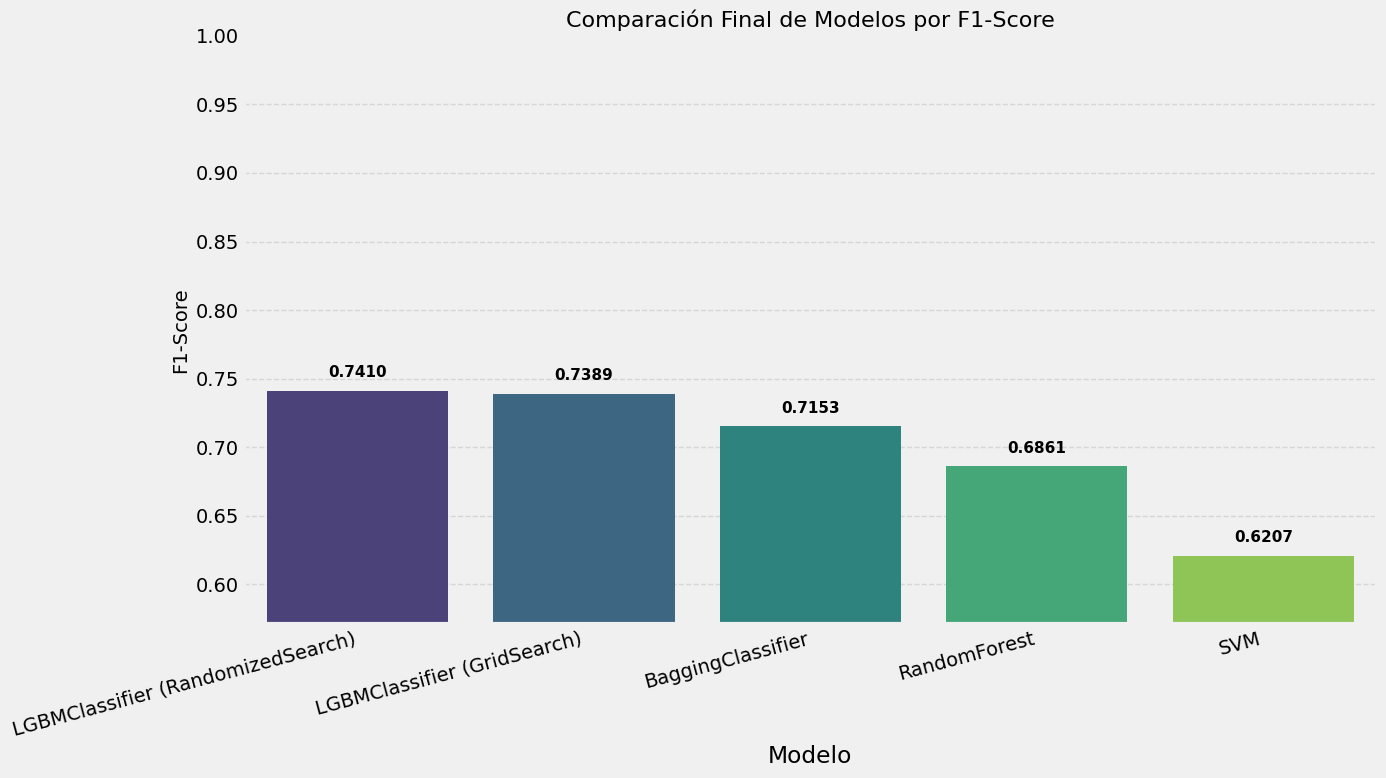


El mejor modelo es: LGBMClassifier (RandomizedSearch) con F1-Score de 0.7410

Comparación entre implementaciones de LGBMClassifier:


,Modelo,F1-Score (Test)
0,LGBMClassifier (GridSearch),0.74
1,LGBMClassifier (RandomizedSearch),0.74


Diferencia de rendimiento: GridSearch es 0.28% peor que RandomizedSearch


In [ ]:
# =====================================================================
# COMPARACIÓN FINAL DE TODOS LOS MODELOS
# =====================================================================

# Usar las variables generadas por la optimización de hiperparámetros
# En lugar de valores fijos, usaremos los valores calculados previamente
lgbm_grid_f1 = lgbm_grid_f1  # Esta variable viene del código anterior
lgbm_randomized_f1 = lgbm_randomized_f1  # Esta variable viene del código anterior

# Recopilar métricas de todos los modelos
model_names = ['LGBMClassifier (GridSearch)', 'LGBMClassifier (RandomizedSearch)', 'BaggingClassifier', 'RandomForest', 'SVM']
f1_scores_test = [lgbm_grid_f1, lgbm_randomized_f1, bagging_f1, rf_f1, svm_f1]

# Crear DataFrame para comparación visual
comparison_df = pd.DataFrame({
    'Modelo': model_names,
    'F1-Score (Test)': f1_scores_test,
})

# Mostrar tabla de comparación
print("\n=== COMPARACIÓN FINAL DE TODOS LOS MODELOS ===")
print("Comparación de Modelos por F1-Score:")
display(comparison_df.sort_values(by='F1-Score (Test)', ascending=False))

# Visualización de comparación
plt.figure(figsize=(14, 8))
sns.barplot(
    x='Modelo',
    y='F1-Score (Test)',
    data=comparison_df.sort_values(by='F1-Score (Test)', ascending=False),
    palette='viridis'
)
plt.title('Comparación Final de Modelos por F1-Score', fontsize=16)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(rotation=15, ha='right')  # Rotar etiquetas para mejor legibilidad
plt.ylim(min(f1_scores_test) - 0.05, 1.0)  # Ajustar escala
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar etiquetas de valor sobre las barras
for i, model in enumerate(comparison_df.sort_values(by='F1-Score (Test)', ascending=False)['Modelo']):
    idx = model_names.index(model)
    plt.text(i, f1_scores_test[idx] + 0.01, f'{f1_scores_test[idx]:.4f}',
             ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Determinar el mejor modelo basado en el conjunto de test
best_model_idx = f1_scores_test.index(max(f1_scores_test))
best_model_name = model_names[best_model_idx]
print(f"\nEl mejor modelo es: {best_model_name} con F1-Score de {max(f1_scores_test):.4f}")

# Comparación específica de métodos de optimización para LGBMClassifier
print("\nComparación entre implementaciones de LGBMClassifier:")
lgbm_comparison = comparison_df[comparison_df['Modelo'].str.contains('LGBMClassifier')]
display(lgbm_comparison)

# Diferencia de rendimiento entre GridSearch y RandomizedSearch
diff_pct = ((lgbm_grid_f1 - lgbm_randomized_f1) / lgbm_randomized_f1) * 100
print(f"Diferencia de rendimiento: GridSearch es {abs(diff_pct):.2f}% {'mejor' if diff_pct > 0 else 'peor'} que RandomizedSearch")

# Parte 13: Optimización con optuna del modelo LGBMClassifier



Esta sección implementa la **optimización de hiperparámetros** usando **Optuna** para mejorar el desempeño de **LGBMClassifier**.

## **1. Carga y Exploración de Datos**
- Se cargan los conjuntos de datos de **entrenamiento** y **prueba**.
- Se identifican **columnas categóricas y numéricas** para su posterior procesamiento.
- Se imprime un resumen de los tipos de datos y ejemplos de valores categóricos.

## **2. Preprocesamiento de Datos**
- Se crea un **pipeline de preprocesamiento** (`ColumnTransformer`) que:
  - **Estandariza** las características numéricas (`StandardScaler`).
  - **Codifica** las variables categóricas (`OneHotEncoder`).
- Se transforma el conjunto de datos y se divide en **80% entrenamiento y 20% prueba**.

## **3. Optimización con Optuna**
- Se define una **función objetivo** para buscar los mejores hiperparámetros del modelo.
- Se utilizan **rangos seguros** para parámetros clave como:
  - `n_estimators`, `learning_rate`, `num_leaves`, `max_depth`, `subsample`, etc.
- Se aplica **validación cruzada estratificada (3 pliegues)** para evaluar el rendimiento del modelo.
- **Optuna ejecuta 1000 pruebas** (`n_trials=1000`) para encontrar la mejor combinación de hiperparámetros.

## **4. Resultados de la Optimización**
- Se imprimen los **mejores hiperparámetros** encontrados.
- Se reporta el **F1-score más alto** obtenido en validación cruzada.

### **Conclusión**
Esta estrategia permite una búsqueda eficiente y automática de hiperparámetros, logrando un modelo **más preciso y optimizado** en la clasificación de niveles de daño en edificios.

In [ ]:
# =====================================================================
# OPTIMIZACIÓN ROBUSTA CON OPTUNA - MANEJO DE DATOS MIXTOS
# =====================================================================
# Cargar los datasets
train_features = pd.read_csv(train_values_url)
train_labels = pd.read_csv(train_labels_url)
test_features = pd.read_csv(test_values_url)

# Combinar características y etiquetas para el conjunto de entrenamiento
train_data = train_features.merge(train_labels, on='building_id', how='left')

print(f"Datos cargados:")
print(f"- Conjunto de entrenamiento: {train_data.shape[0]} registros, {train_data.shape[1]} columnas")
print(f"- Conjunto de prueba externo: {test_features.shape[0]} registros, {test_features.shape[1]} columnas")

# Separar características y objetivo
X = train_data.drop(['building_id', 'damage_grade'], axis=1)
y = train_data['damage_grade']

# Examinar los tipos de datos para identificar columnas categóricas
print("\nTipos de datos en el conjunto:")
print(X.dtypes.value_counts())

# Identificar columnas categóricas y numéricas
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nColumnas categóricas identificadas: {len(categorical_columns)}")
print(f"Columnas numéricas identificadas: {len(numerical_columns)}")

if len(categorical_columns) > 0:
    print("Ejemplos de valores categóricos:")
    for col in categorical_columns[:3]:  # Mostrar ejemplo de las primeras 3
        unique_vals = X[col].nunique()
        print(f"{col}: {unique_vals} valores únicos")
        print(f"Ejemplo: {X[col].iloc[0]}")

# =====================================================================
# 2. PREPROCESAMIENTO DE DATOS
# =====================================================================

print("\nCreando pipeline de preprocesamiento...")

# Crear pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
    ],
    remainder='passthrough'
)

# Aplicar preprocesamiento
X_prepared = preprocessor.fit_transform(X)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Preprocesamiento completado:")
print(f"- Entrenamiento: {X_train.shape[0]} registros, {X_train.shape[1]} características")
print(f"- Prueba: {X_test.shape[0]} registros, {X_test.shape[1]} características")

# =====================================================================
# 3. OPTIMIZACIÓN CON OPTUNA
# =====================================================================

def objective(trial):
    """Función objetivo para Optuna con manejo de errores"""
    try:
        # Parámetros con rangos seguros
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'num_leaves': trial.suggest_int('num_leaves', 20, 80),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
            'random_state': 42,
            'verbose': -1
        }

        # Crear y evaluar modelo
        model = LGBMClassifier(**param)

        # Validación cruzada manual para mayor control
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = []

        for train_idx, val_idx in cv.split(X_train, y_train):
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model.fit(X_fold_train, y_fold_train)
            y_pred = model.predict(X_fold_val)
            fold_score = f1_score(y_fold_val, y_pred, average='micro')
            scores.append(fold_score)

        return np.mean(scores)

    except Exception as e:
        print(f"Error en trial: {e}")
        return float('-inf')

print("\nIniciando optimización con Optuna...")
print("Este proceso puede tardar varios minutos...")

# Crear y ejecutar estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

print("\nOptimización completada!")
print("\nMejores hiperparámetros encontrados:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

print(f"\nMejor F1-score (CV): {study.best_value:.4f}")

Datos cargados:
- Conjunto de entrenamiento: 260601 registros, 40 columnas
- Conjunto de prueba externo: 86868 registros, 39 columnas

Tipos de datos en el conjunto:
int64     30
object     8
Name: count, dtype: int64

Columnas categóricas identificadas: 8
Columnas numéricas identificadas: 30
Ejemplos de valores categóricos:
land_surface_condition: 3 valores únicos
Ejemplo: t
foundation_type: 5 valores únicos
Ejemplo: r
roof_type: 3 valores únicos
Ejemplo: n

Creando pipeline de preprocesamiento...


[I 2025-03-11 14:14:10,735] A new study created in memory with name: no-name-1ff1e56a-602c-465d-928c-7e4317746acc


Preprocesamiento completado:
- Entrenamiento: 208480 registros, 68 características
- Prueba: 52121 registros, 68 características

Iniciando optimización con Optuna...
Este proceso puede tardar varios minutos...


[I 2025-03-11 14:14:22,295] Trial 0 finished with value: 0.7322285061232203 and parameters: {'n_estimators': 344, 'learning_rate': 0.14808103407122988, 'num_leaves': 33, 'max_depth': 9, 'min_child_samples': 64, 'subsample': 0.7865905629678998, 'colsample_bytree': 0.8061149666480688, 'reg_alpha': 0.016587620099385192, 'reg_lambda': 0.70407270061255}. Best is trial 0 with value: 0.7322285061232203.
[I 2025-03-11 14:14:28,567] Trial 1 finished with value: 0.7189418573446963 and parameters: {'n_estimators': 132, 'learning_rate': 0.10290853085668077, 'num_leaves': 45, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.7975553659609378, 'colsample_bytree': 0.8033665958521787, 'reg_alpha': 0.49448610453236985, 'reg_lambda': 0.7075899882243772}. Best is trial 0 with value: 0.7322285061232203.
[I 2025-03-11 14:14:34,149] Trial 2 finished with value: 0.6933902448728712 and parameters: {'n_estimators': 254, 'learning_rate': 0.10528495239533472, 'num_leaves': 27, 'max_depth': 3, 'min_child_sa


Optimización completada!

Mejores hiperparámetros encontrados:
  n_estimators: 487
  learning_rate: 0.14427229737735045
  num_leaves: 80
  max_depth: 10
  min_child_samples: 69
  subsample: 0.8405219979024641
  colsample_bytree: 0.7577832081383069
  reg_alpha: 0.9034245732091797
  reg_lambda: 0.27598432461955674

Mejor F1-score (CV): 0.7401


# **Parte 14: Predicción en datos de prueba y generación de archivo**

En esta sección se entrena el **modelo final optimizado** con los mejores hiperparámetros obtenidos a través de **Optuna** y se evalúa su desempeño.

## **1. Evaluación en Conjunto de Prueba Interno**
- Se entrena el modelo **LightGBM** con los **mejores parámetros** (`study.best_params`).
- Se calculan las métricas de desempeño:
  - **F1-score (micro)**
  - **Accuracy**
- Se genera un **reporte de clasificación** con precisión, recall y F1-score por clase.
- Se visualiza la **matriz de confusión** y se guarda como imagen (`optuna_confusion_matrix.png`).

## **2. Entrenamiento con Todos los Datos**
- Se entrena el modelo con **todo el conjunto de entrenamiento** disponible para mejorar la generalización.

## **3. Predicciones en Conjunto de Prueba Externo**
- Se preprocesan los datos de prueba externos.
- Se generan **predicciones** para el conjunto de prueba.
- Se guarda un **archivo de predicciones** (`submission_optuna_lgbm.csv`).
- Se muestra la **distribución de las predicciones** para analizar el balance de clases.

## **4. Guardado del Modelo Final**
- Se empaqueta el modelo junto con el preprocesador y los hiperparámetros óptimos.
- Se guarda en un archivo (`optuna_optimized_model.pkl`) para su uso en producción o futuras evaluaciones.


Este proceso garantiza que el modelo está completamente entrenado, optimizado y listo para realizar predicciones de manera eficiente.


In [ ]:
# =====================================================================
# 1. ENTRENAMIENTO Y EVALUACIÓN DEL MODELO FINAL
# =====================================================================

# Entrenar modelo final con los mejores parámetros
print("\nEntrenando modelo final con los mejores hiperparámetros...")
best_params = study.best_params
best_model = LGBMClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Evaluar en conjunto de prueba
y_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred, average='micro')
print(f"\nResultados en conjunto de prueba interno:")
print(f"F1-score (micro): {test_f1:.4f}")
print(f"Accuracy: {(y_test == y_pred).mean():.4f}")

# Mostrar reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(np.unique(y)),
            yticklabels=sorted(np.unique(y)))
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.savefig('optuna_confusion_matrix.png')
plt.close()
print("Matriz de confusión guardada como 'optuna_confusion_matrix.png'")

# =====================================================================
# 2. ENTRENAMIENTO DEL MODELO FINAL CON TODOS LOS DATOS
# =====================================================================

print("\nEntrenando modelo final con todos los datos disponibles...")
final_model = LGBMClassifier(**best_params, random_state=42)
final_model.fit(X_prepared, y)

# =====================================================================
# 3. PREDICCIONES EN CONJUNTO DE PRUEBA EXTERNO
# =====================================================================

print("\nGenerando predicciones para el conjunto de prueba externo...")

# Preprocesar datos de prueba
X_test_external = test_features.drop('building_id', axis=1)
X_test_external_prepared = preprocessor.transform(X_test_external)

# Generar predicciones
predictions = final_model.predict(X_test_external_prepared)

# Crear archivo de submisión
submission = pd.DataFrame({
    'building_id': test_features['building_id'],
    'damage_grade': predictions
})

submission_file = 'submission_optuna_lgbm.csv'
submission.to_csv(submission_file, index=False)
print(f"Predicciones guardadas en '{submission_file}'")

# Mostrar distribución de predicciones
print("\nDistribución de predicciones:")
pred_distribution = pd.Series(predictions).value_counts(normalize=True).sort_index() * 100
print(pred_distribution)

# =====================================================================
# 4. GUARDAR MODELO FINAL
# =====================================================================

# Guardar modelo y componentes necesarios
model_package = {
    'model': final_model,
    'preprocessor': preprocessor,
    'best_params': best_params,
    'metadata': {
    }
}

with open('optuna_optimized_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("\nModelo final guardado como 'optuna_optimized_model.pkl'")

print("\n=== CONCLUSIONES ===")
print(f"1. Se optimizó exitosamente un modelo LightGBM con Optuna")
print(f"2. F1-score en validación interna: {test_f1:.4f}")
print(f"3. Hiperparámetros óptimos encontrados para máxima generalización")


Entrenando modelo final con los mejores hiperparámetros...

Resultados en conjunto de prueba interno:
F1-score (micro): 0.7485
Accuracy: 0.7485

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.68      0.54      0.60      5025
           2       0.75      0.85      0.80     29652
           3       0.77      0.64      0.70     17444

    accuracy                           0.75     52121
   macro avg       0.73      0.68      0.70     52121
weighted avg       0.75      0.75      0.74     52121

Matriz de confusión guardada como 'optuna_confusion_matrix.png'

Entrenando modelo final con todos los datos disponibles...

Generando predicciones para el conjunto de prueba externo...
Predicciones guardadas en 'submission_optuna_lgbm.csv'

Distribución de predicciones:
1    7.45
2   64.69
3   27.86
Name: proportion, dtype: float64

Modelo final guardado como 'optuna_optimized_model.pkl'

=== CONCLUSIONES ===
1. Se optimizó exitosamente un mo